上一章中贝叶斯推断是关于基于数据和先验知识，通过贝叶斯公式计算后验概率，从而得到后验分布的过程。但是现实中远没有这么简单，成功的贝叶斯分析还有很多其它挑战。    
本章将讨论其中的一些，包括检验模型假设、诊断推理结果和模型比较[原文链接](https://bayesiancomputationbook.com/markdown/chp_02.html)。

## 2.1. 推断之前和之后都有要做的事情！

除推断外，一次成功的贝叶斯建模的工作列举：

- 通过数值方法诊断推断结果质量；
- 模型批判，评价模型假设和模型预测结果；
- 模型比较，选择模型或者模型混合；
- 为特定受众准备结果。    

以上工作统称为**贝叶斯模型探索分析（Exploratory Analysis of Bayesian Models）**。

## 2.2. 理解你的假设
选择先验的一个问题是很难理解它们在模型计算中的效果。基于先验分布预测是一种理解假设的好方法。通过仅从先验预测分布抽样得到观察数据，我们完成从参数空间到观测空间的转换（参数分布 -> 参数 -> 先验预测分布 -> 观测值）。
这被称为**prior predictive checks**。    
    
举一个对足球建模的例子，我们感兴趣的是点球得分率。    

![](football_sketch.png)

模型假设期望射门角度$\alpha$服从正态分布，进球概率模型为：
$$p\left(|\alpha| < \tan^{-1}\left(\frac{L}{x}\right)\right) = 2\Phi\left(\frac{\tan^{-1}\left(\frac{L}{x}\right)}{\sigma}\right) - 1
$$

上述公式表达的是，足球射出角度$\alpha$在±$\tan^{-1}\left(\frac{L}{x}\right)$的概率（这样才能进球），其中$L$是球门二分之一宽度，$x$是球门中心到球员的距离。球员会尽量踢直线，但是有各种因素影响导致波动从而有标准差$\sigma$    
    
上述公式中唯一未知的参数是$\sigma$，我们可以选择它的先验来建模，例如服从Half-normal分布。则以上模型为：   
$$\sigma \sim \mathcal{HN}(\sigma_{\sigma})$$

$$\text{p\_goal} = 2\Phi\left(\frac{\tan^{-1}\left(\frac{L}{x}\right)}{\sigma}\right) - 1$$

$$Y \sim \text{Bin}(n=1, p=\text{p\_goal})$$    
    
我们很难直接抉择$\sigma_{\sigma}$怎么选择，但是我们可以通过先验预测分布来理解它的影响。

In [1]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from scipy import stats
from pytensor import tensor as tt
import pandas as pd

In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
np.random.seed(5201)

In [3]:
half_length = 3.66  # meters
penalty_point = 11  # meters
def Phi(x):
    """Calculates the standard normal cumulative distribution function."""
    return 0.5 + 0.5 * tt.erf(x / tt.sqrt(2.0))

ppss = []
sigmas_deg = [5, 20, 60]
sigmas_rad = np.deg2rad(sigmas_deg)
for sigma in sigmas_rad:
    with pm.Model() as model:
        σ = pm.HalfNormal("σ", sigma)
        α = pm.Normal("α", 0, σ)
        p_goal = pm.Deterministic("p_goal", 2 * Phi(tt.arctan(half_length / penalty_point) / σ) - 1)
        pps = pm.sample_prior_predictive(250)
        ppss.append(pps)

Sampling: [α, σ]
Sampling: [α, σ]
Sampling: [α, σ]


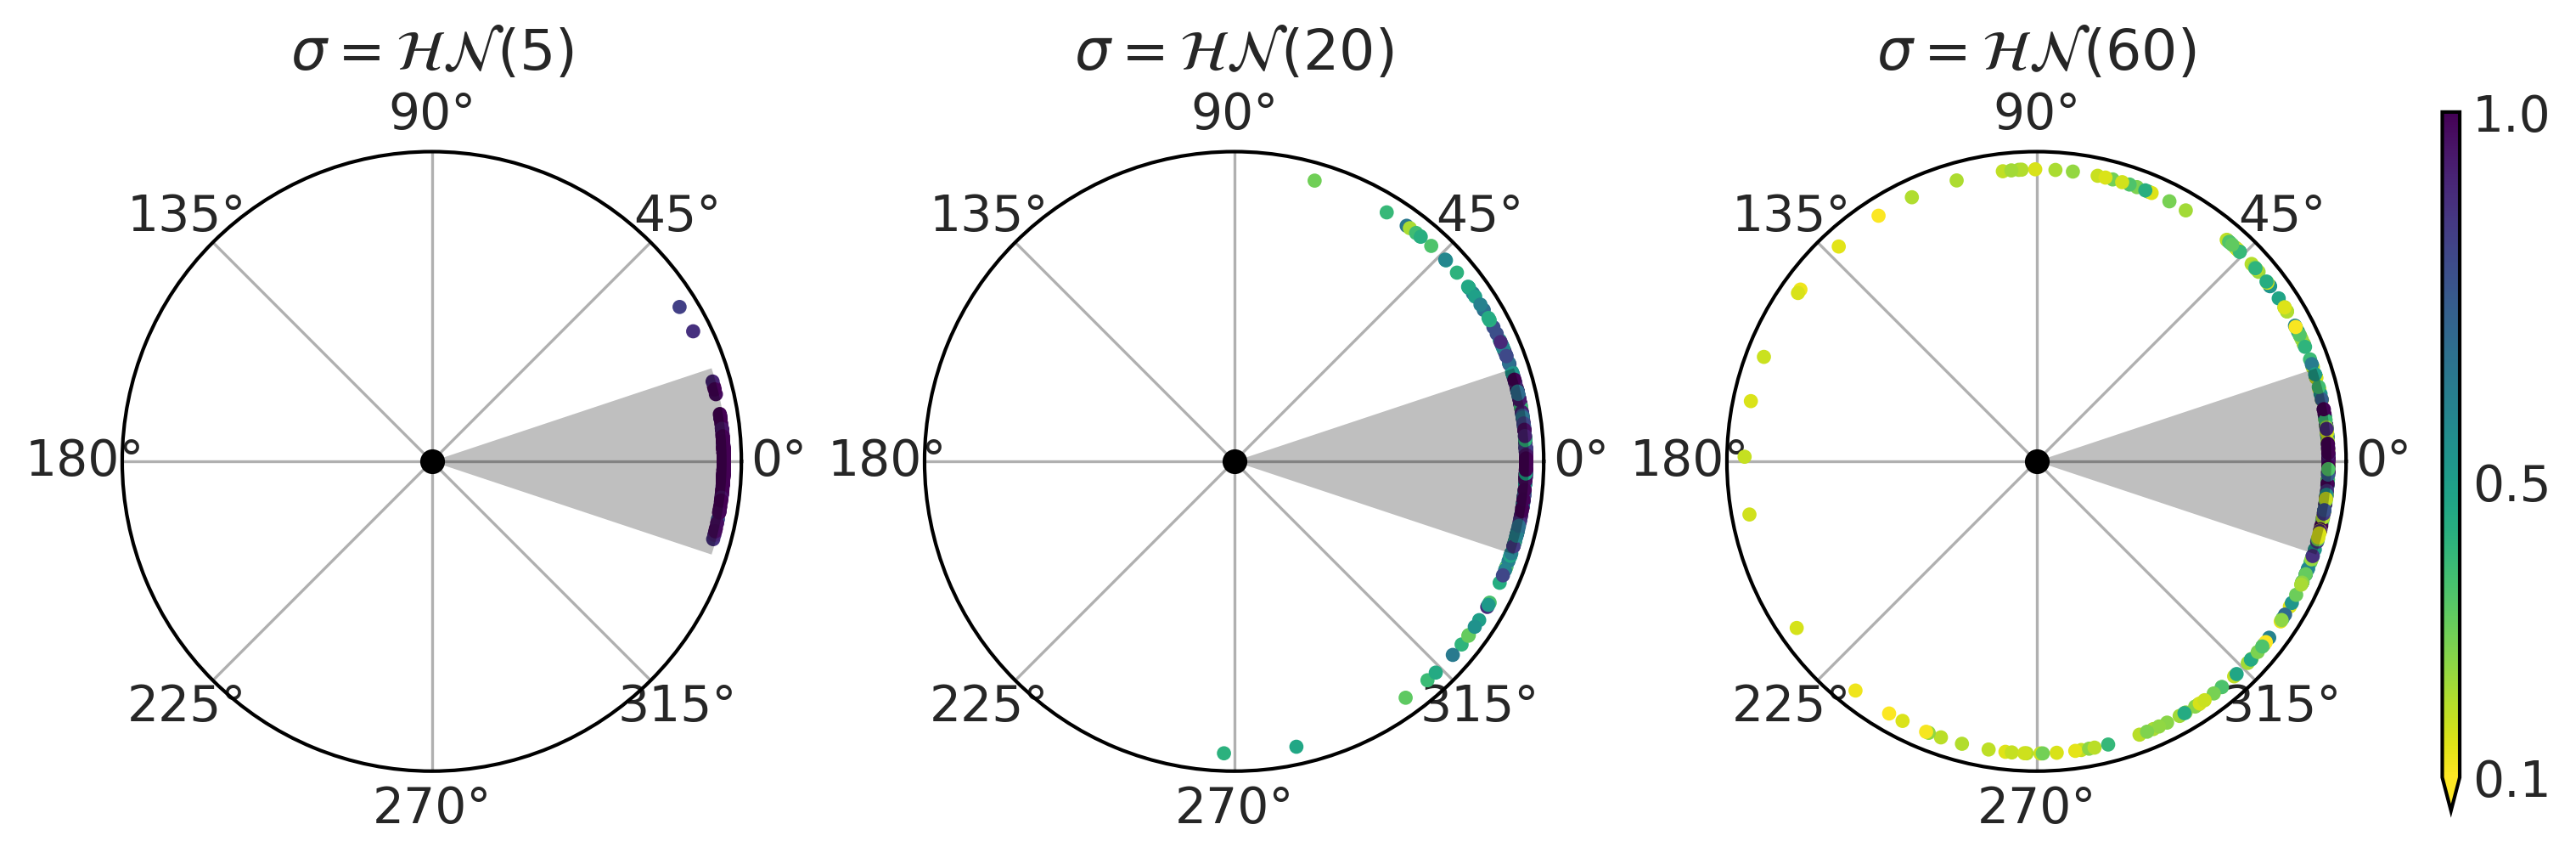

In [4]:
fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection="polar"), figsize=(10, 4))

max_angle = np.arctan(half_length/penalty_point)

for sigma, pps, ax in zip(sigmas_deg, ppss, axes):
    cutoff = pps.prior.data_vars.get("p_goal")[0] > 0.1
    cax = ax.scatter(pps.prior.data_vars.get("α")[0][cutoff], np.ones_like(pps.prior.data_vars.get("α")[0][cutoff]), c=pps.prior.data_vars.get("p_goal")[0][cutoff],
               marker=".", cmap="viridis_r", vmin=0.1)
    ax.fill_between(np.linspace(-max_angle, max_angle, 100), 0, 1.01, alpha=0.25)
    ax.set_yticks([])
    ax.set_title(f"$\sigma = \mathcal{{HN}}({sigma})$")
    ax.plot(0,0, 'o')
fig.colorbar(cax, extend="min", ticks=[1, 0.5, 0.1], shrink=0.7, aspect=40)

对$\sigma_\sigma$ 分别取5,20,60的三个先验分布向后采样得到上述结果。    
灰色区域表示「射门期望能进球」范围（对应$\alpha$，没有风、摩擦等干扰因素），颜色表示进球概率（对应p_goal，实际收干扰后的概率）。可以发现即使射的在灰色范围内，也不能100%进球。而对60来说，某些射向相反方向也有可能进球，这个分布可能不太好。     
    
此时我们可以做更多选择：我们可以重新思考模型结构引入更多几何知识；或者我们可以使用先验来减少nonsensical的结果，或直接拟合看数据信息是否足够让后验结果合理。    
    
下面的示例为一个逻辑回归模型，它包含一些二元变量，每个变量回归系数的先验为$\mathcal{N}(0, 1)$。

Text(0.34, -0.075, 'mean of the simulated data')

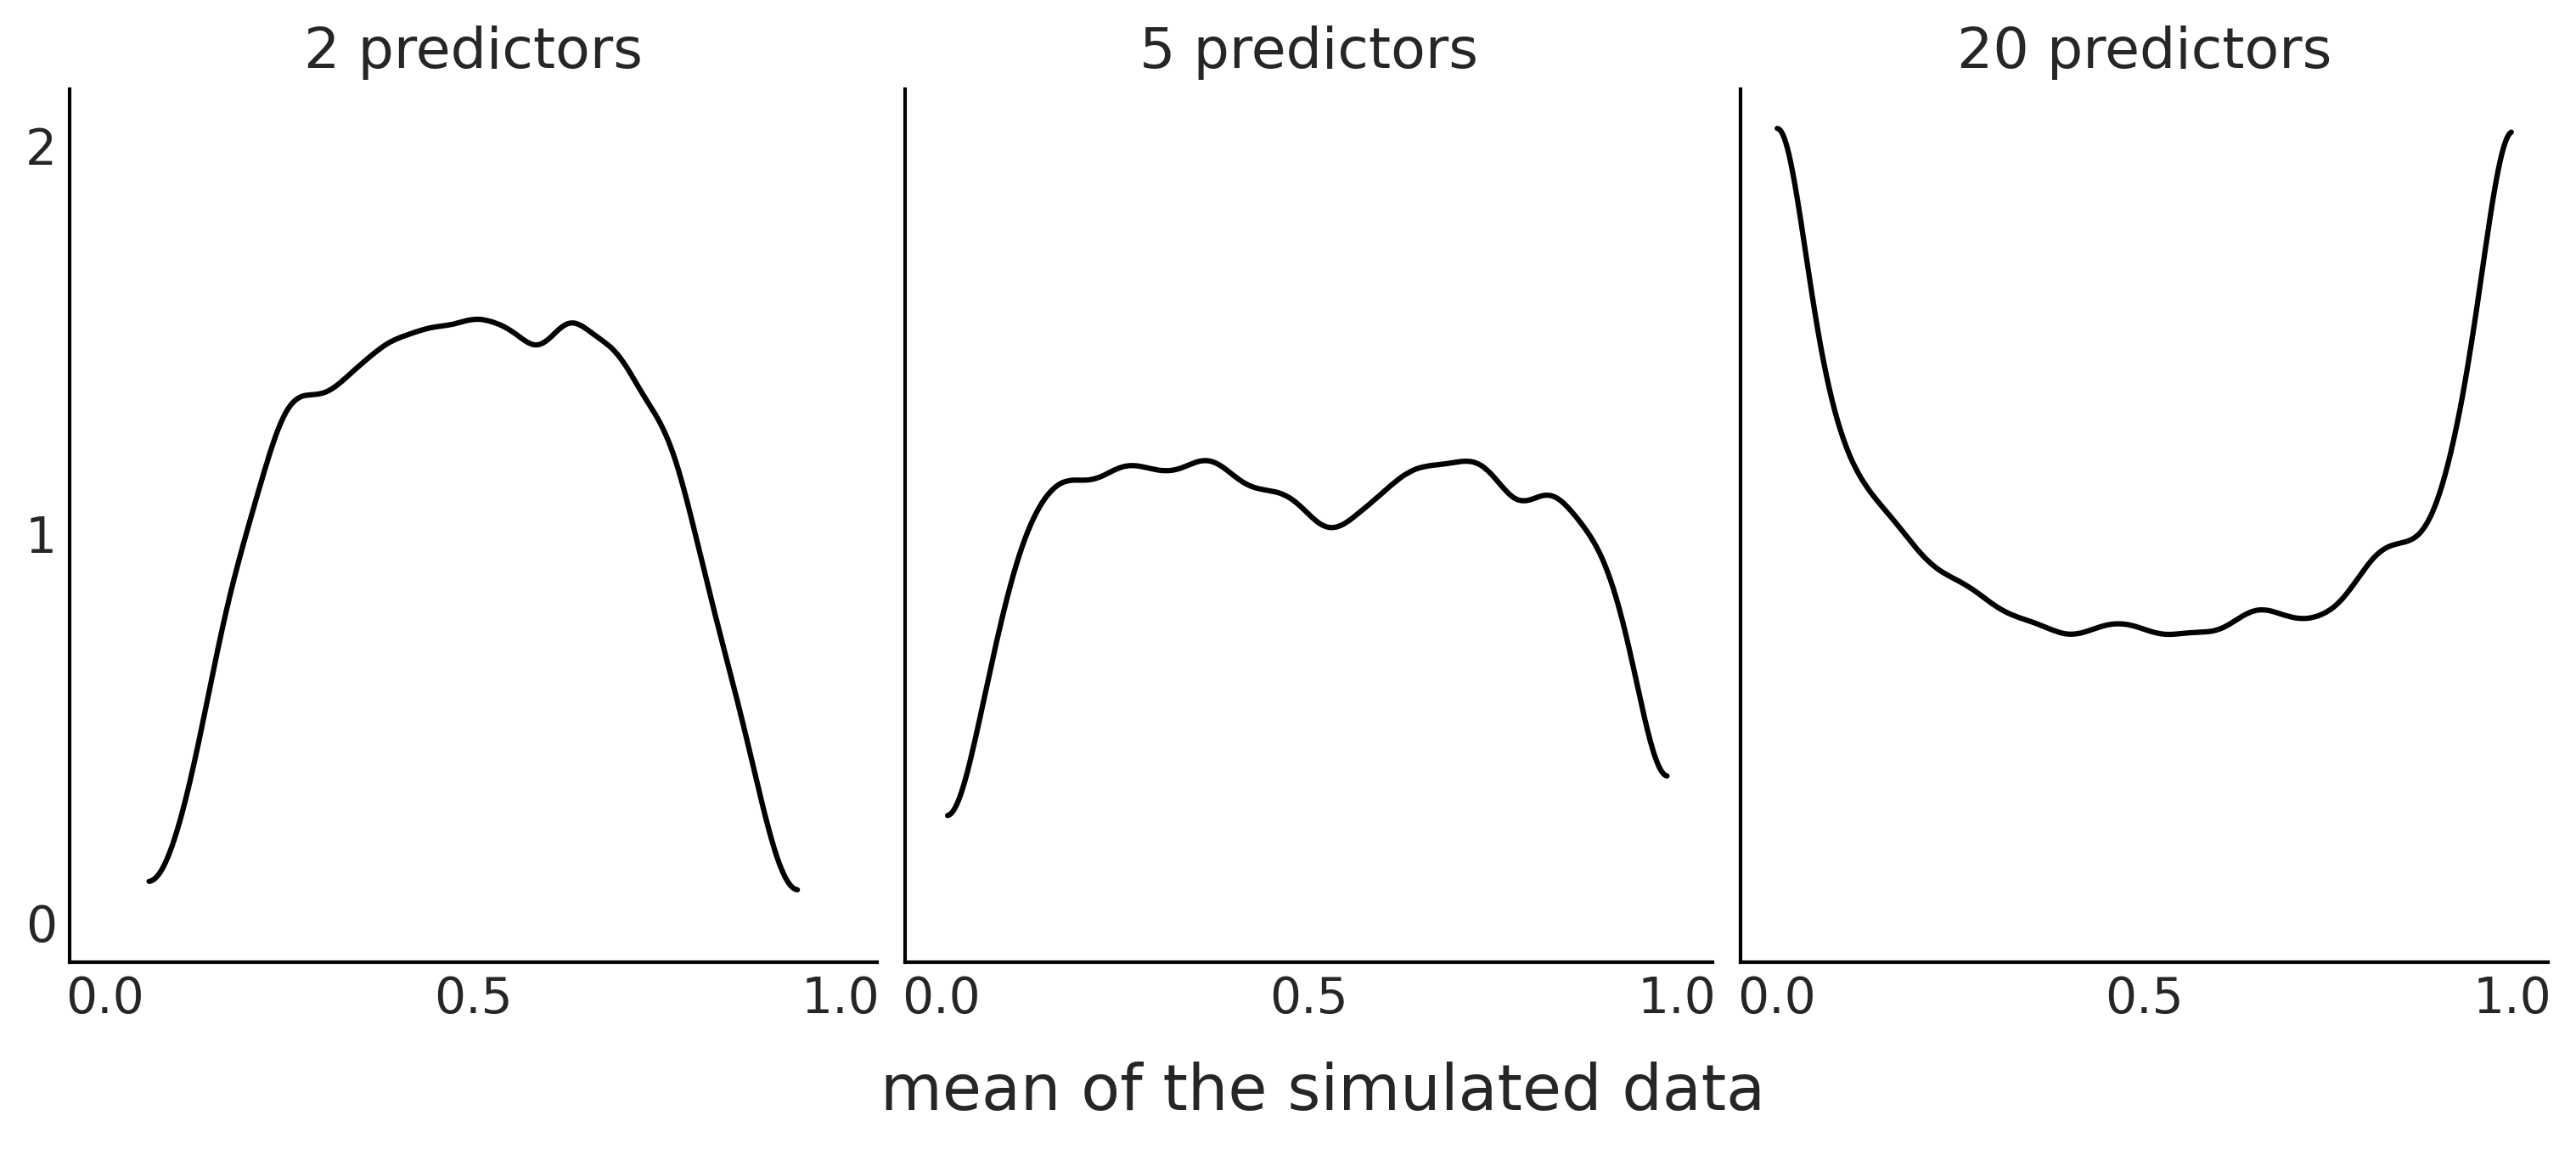

In [5]:
from scipy.special import expit
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True,  sharey=True)
axes = np.ravel(axes)

for dim, ax in zip([2, 5, 20], axes):
    β = np.random.normal(0, 1, size=(10000, dim))
    X = np.random.binomial(n=1, p=0.75, size=(dim, 500))
    az.plot_kde(expit(β @ X).mean(1), ax=ax)
    ax.set_title(f"{dim} predictors")
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 1, 2])

fig.text(0.34, -0.075, size=18, s="mean of the simulated data")

可以发现随着predictors的增加先验预测结果分布更偏向于产生极值。
因此我们可能需要一些更强的正则化先验（比如拉普拉斯分布）以保持模型远离极值。    
    
上述的两个例子都表明先验不能孤立地理解，我们需要将它们放在特定模型的背景下。

## 2.3. 理解你的预测

我们可以通过**posterior predictive checks**来理解模型预测的效果。基本思想是后验预测分布抽样应该与观测数据类似。    
    
下图是一个binomial model的例子。

In [6]:
Y = stats.bernoulli(0.7).rvs(100)
with pm.Model() as model:
    θ = pm.Beta("θ", 1, 1)
    y_obs = pm.Binomial("y_obs",n=1, p=θ, observed=Y)
    trace_b = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [7]:
pred_dist = pm.sample_posterior_predictive(trace_b, model=model).posterior_predictive.y_obs.values[0]

Sampling: [y_obs]


Text(0, 0.5, 'probability')

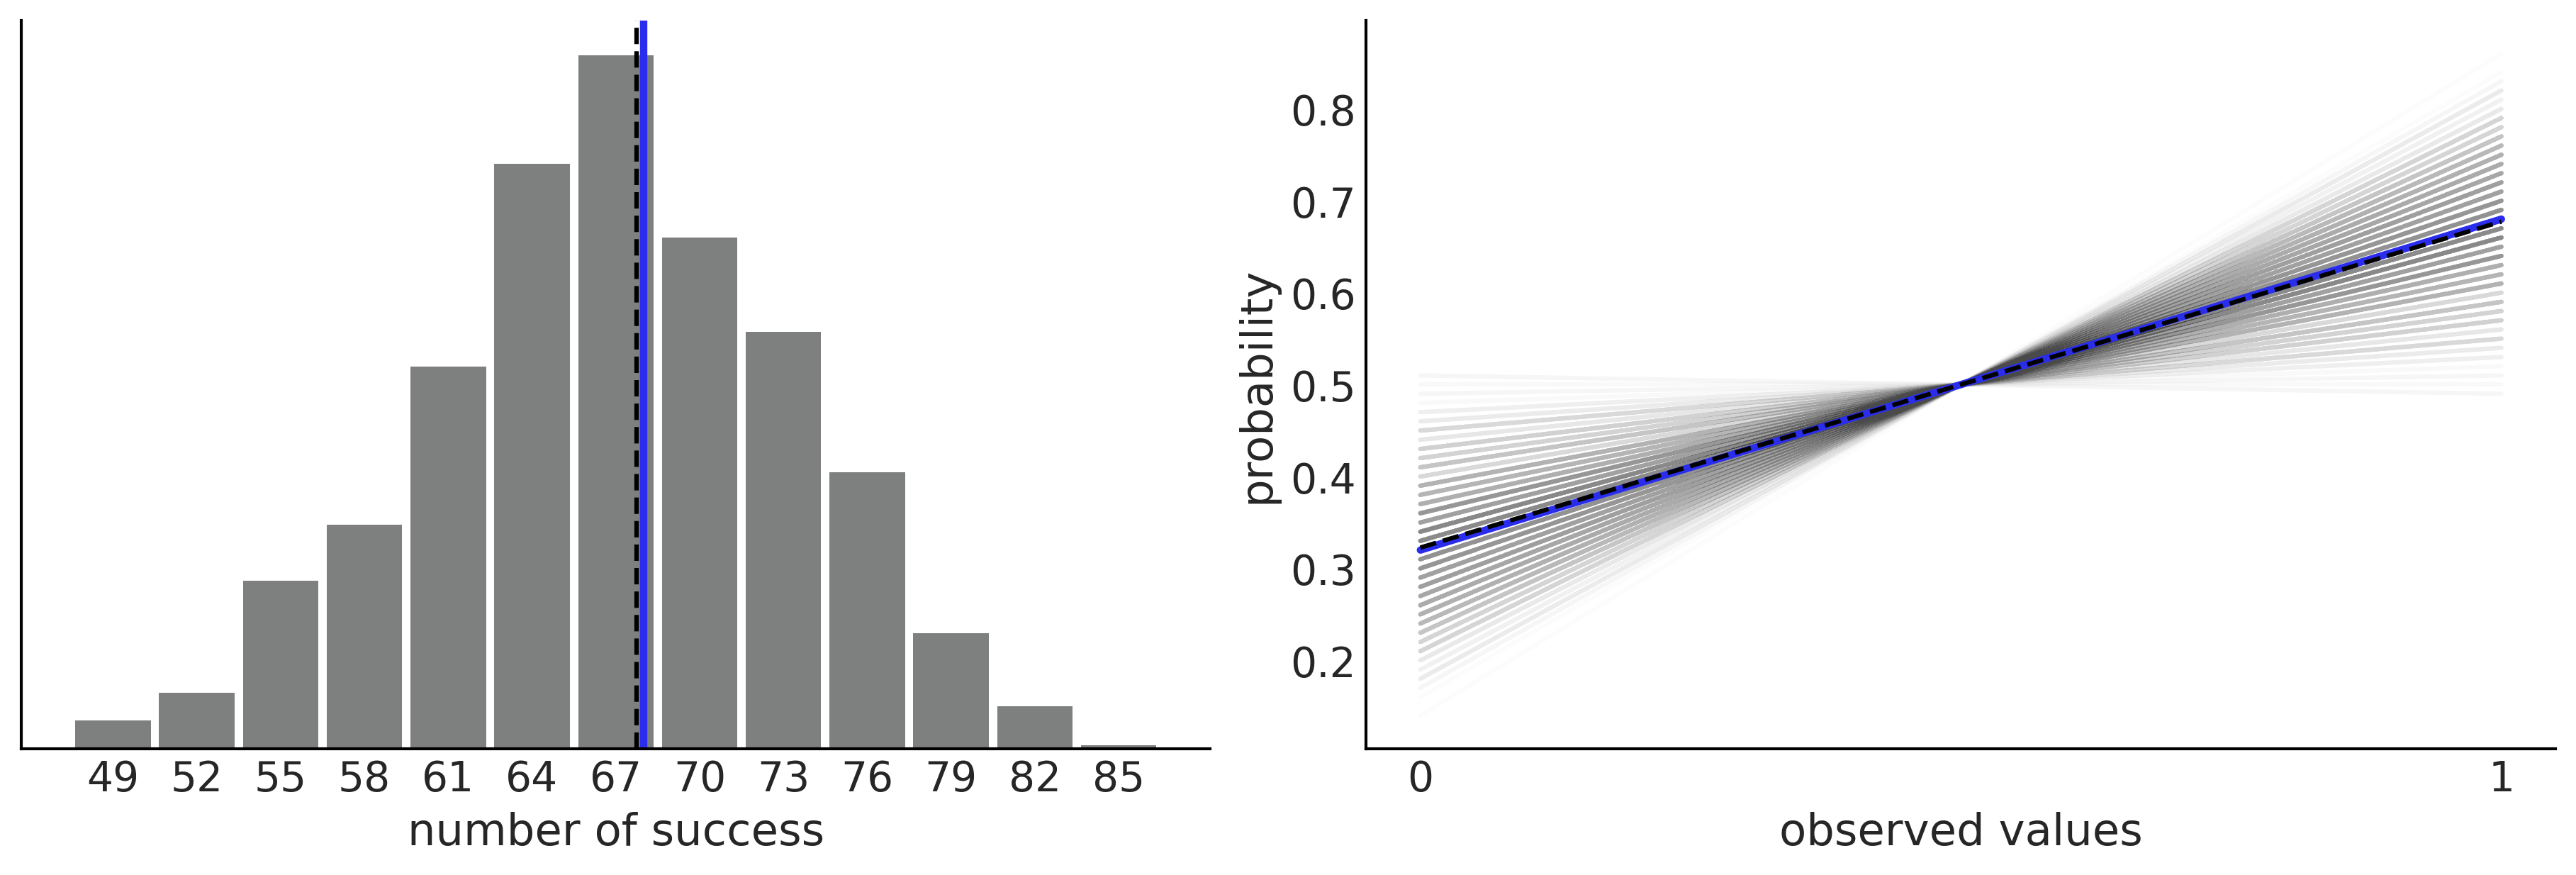

In [8]:
_, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

az.plot_dist(pred_dist.sum(1),
             hist_kwargs={"color":"C2"}, ax=ax[0])
ax[0].axvline(Y.sum(), color="C4", lw=2.5);
ax[0].axvline(pred_dist.sum(1).mean(), color="k", ls="--")
ax[0].set_yticks([])
ax[0].set_xlabel("number of success")

pps_ = pred_dist.mean(1)
ax[1].plot((np.zeros_like(pps_), np.ones_like(pps_)), (1-pps_, pps_), 'C1', alpha=0.01)

ax[1].plot((0, 1), (1-Y.mean(), Y.mean()), 'C4', lw=2.5)
ax[1].plot((0, 1), (1-pps_.mean(), pps_.mean()), 'k--')
ax[1].set_xticks((0,1))
ax[1].set_xlabel("observed values")
ax[1].set_ylabel("probability")

左图可以比较观测成功数据（蓝色）和后验预测的成功数值分布。右边是另一种概率方式的呈现。上图可知我们后验模型在平均值方面的预测很好。      
     
后验预测还可以数值进行测试。一种计算方法是：$$p_{B} = p(T_{sim} \leq T_{obs} \mid \tilde Y)$$

    
其中$p_{B}$是Bayesian p-value：仿真生成的统计量$T_{sim}$小于等于观测统计量$T_{obs}$的概率。统计量$T$可以是任意指标。在上面的例子中，$T_{obs}$是成功率（均值）并且比较后验预测结果分布的成功率$T_{sim}$。当 $p_{B} = 0.5$ 时 $T_{sim}$ 一半大于观测结果一半小于观测结果，这是拟合良好的预期结果。   
    
以下是Bayesian p-value的绘制，注意 `az.plot_bpv(idata, kind="p_value")` 新版本绘制有误

In [12]:
idata = az.from_dict(posterior_predictive={"y":pred_dist.reshape(2, 500, 100)}, observed_data={"y":Y})

/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


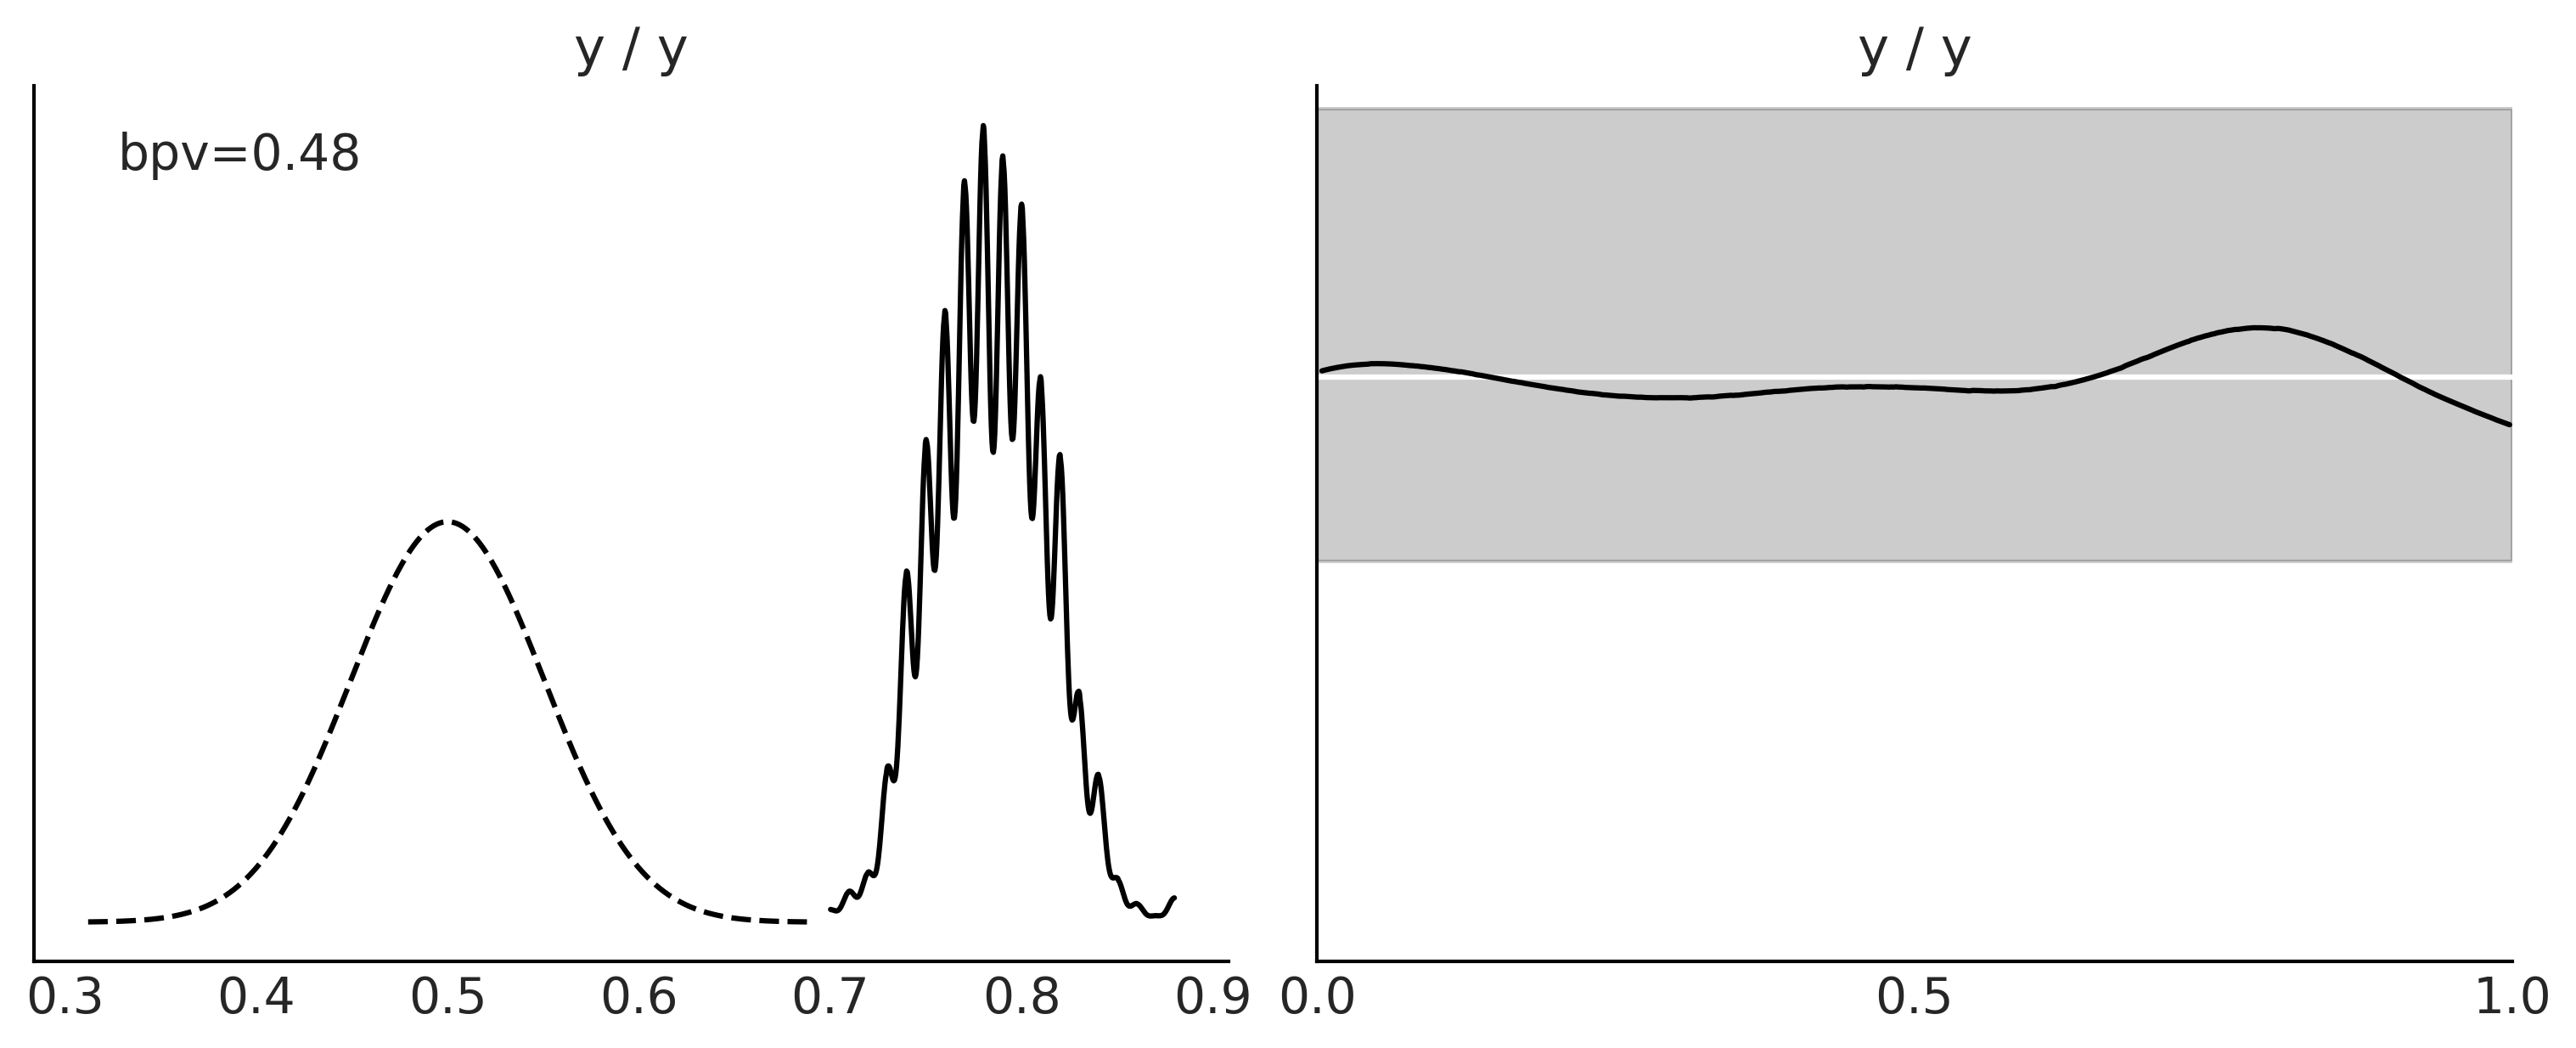

In [15]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
az.plot_bpv(idata, kind="p_value", ax=ax[0])
ax[0].legend([f"bpv={(Y.mean() > pred_dist.mean(1)).mean():.2f}"], handlelength=0)
az.plot_bpv(idata, kind="u_value", ax=ax[1])
ax[1].set_yticks([])
ax[1].set_xticks([0., 0.5, 1.])

以上是 Beta-Binomial model 的后验预测分布。左图显示有误待修复，右图中白色代表理想情况，黑线是预测值比例的KDE。

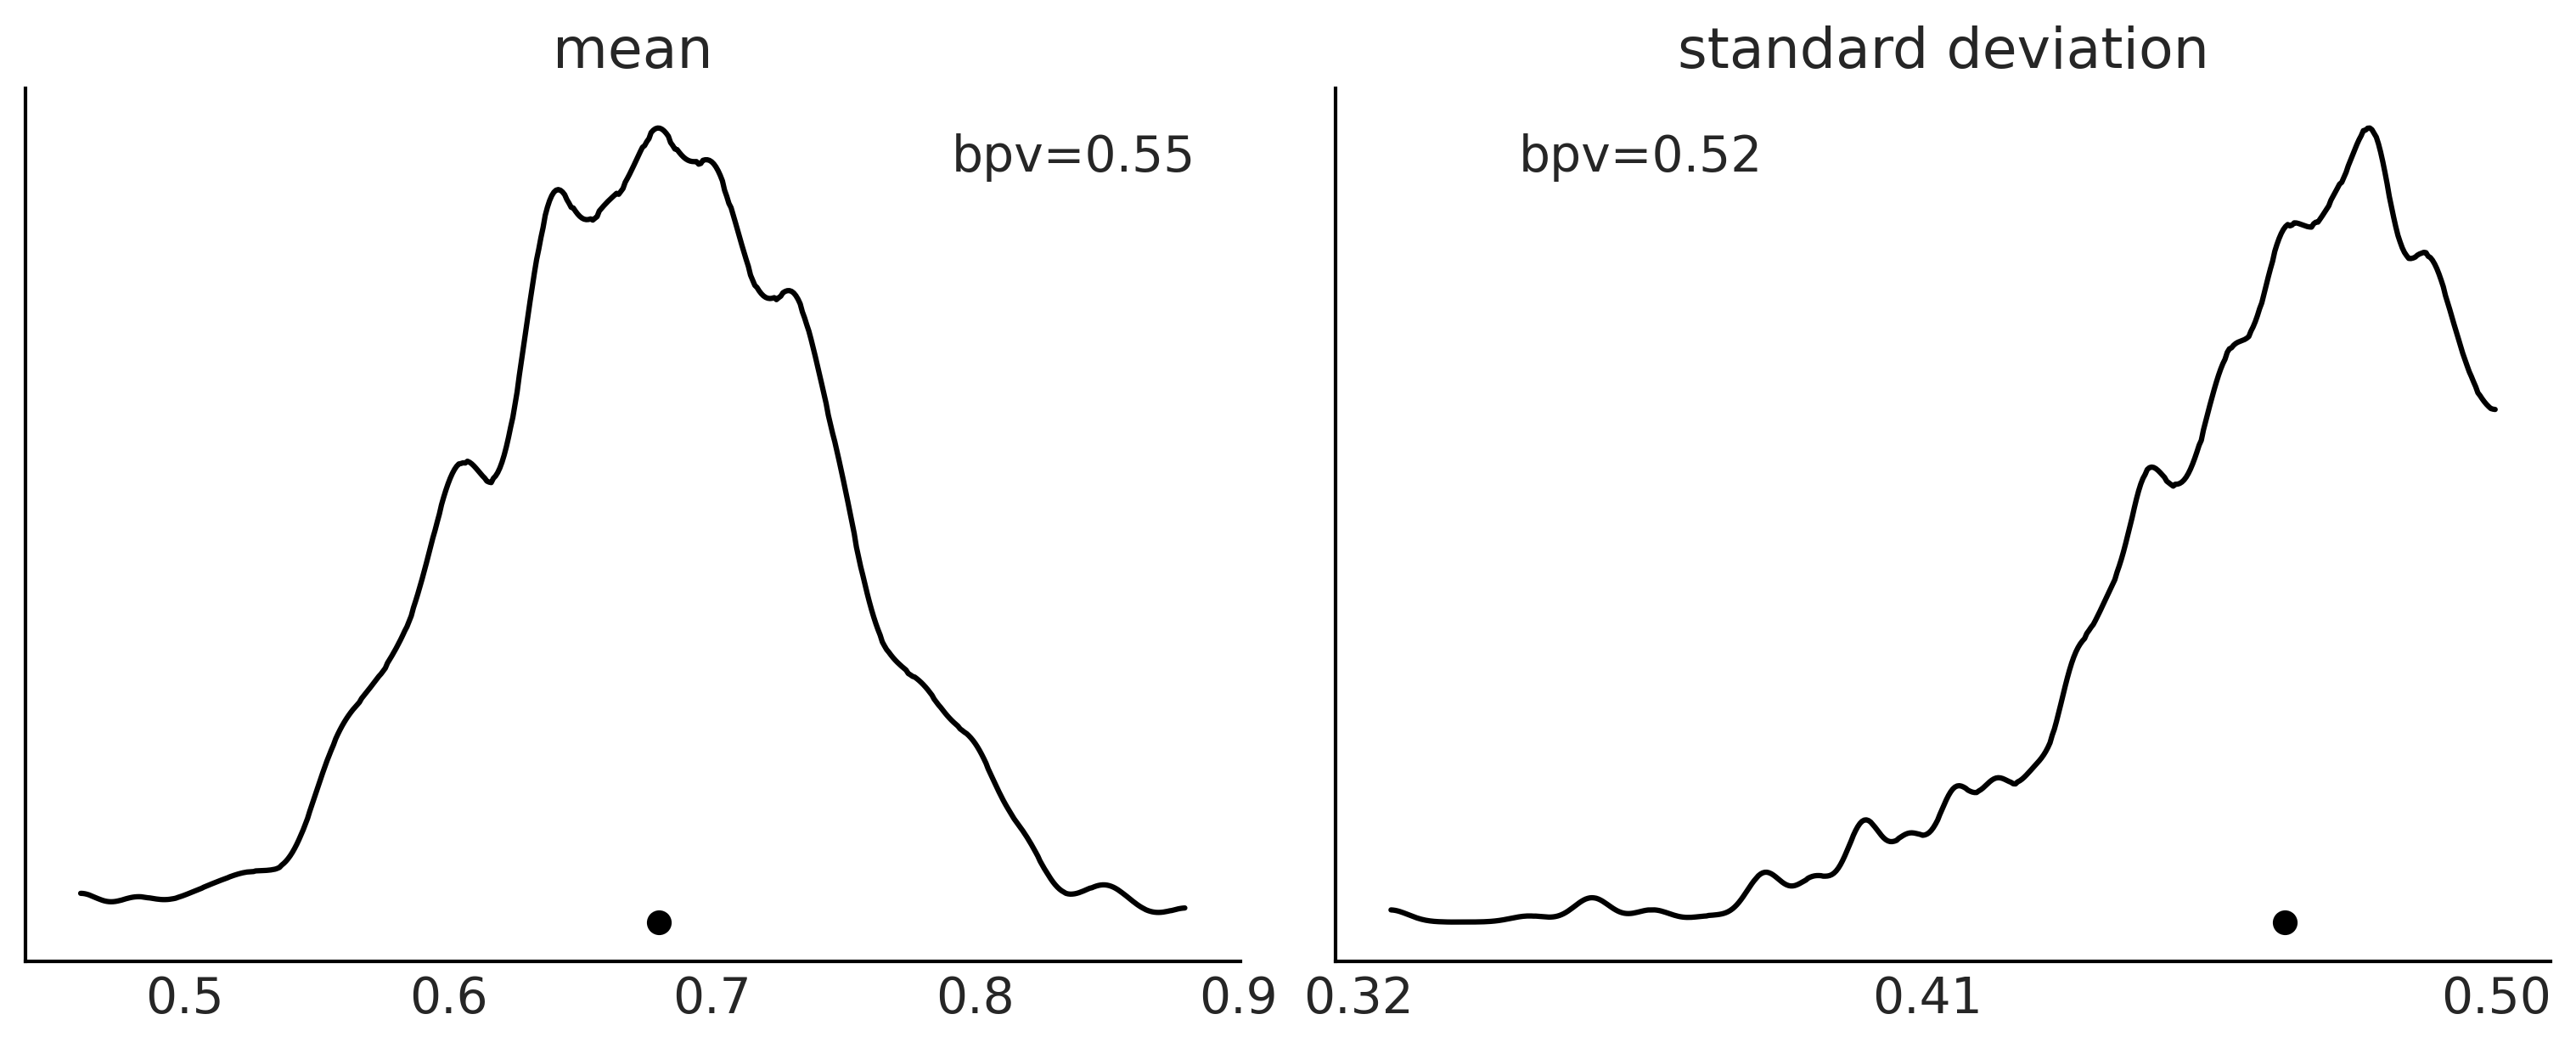

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
az.plot_bpv(idata, kind="t_stat", t_stat="mean", ax=ax[0])
ax[0].set_title("mean")
az.plot_bpv(idata, kind="t_stat", t_stat="std", ax=ax[1])
ax[1].set_title("standard deviation")
ax[1].set_xticks([0.32, 0.41, 0.5])

有很多 $T$ 统计量可以被选择。上图中左边为均值，右边为标准差。    
     
下图有4个例子来帮助我们建立直觉。下图的蓝色线是同一份观测数据来自正态分布，并且有四个后验样本。

In [ ]:
n_obs = 500
samples = 2000
y_obs = np.random.normal(0, 1, size=n_obs)

idata1 = az.from_dict(posterior_predictive={"y":np.random.normal(0.5, 1, size=(1, samples, n_obs))},
                      observed_data={"y":y_obs})

idata2 = az.from_dict(posterior_predictive={"y":np.random.normal(0, 2, size=(1, samples, n_obs))},
                      observed_data={"y":y_obs})

idata3 = az.from_dict(posterior_predictive={"y":np.random.normal(0, 0.5, size=(1, samples,n_obs))},
                      observed_data={"y":y_obs})

idata4 = az.from_dict(posterior_predictive={"y":np.concatenate(
                                                [np.random.normal(-0.25, 1, size=(1, samples//2, n_obs)),
                                                 np.random.normal(0.25, 1, size=(1, samples//2, n_obs))]
                                                                )},
                      observed_data={"y":y_obs})

idatas = [idata1,
          idata2,
          idata3,
          idata4,
]

/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:241: FutureWarning: color has been deprecated in favor of colors
  warnings.warn("color has been deprecated in favor of colors", FutureWarning)


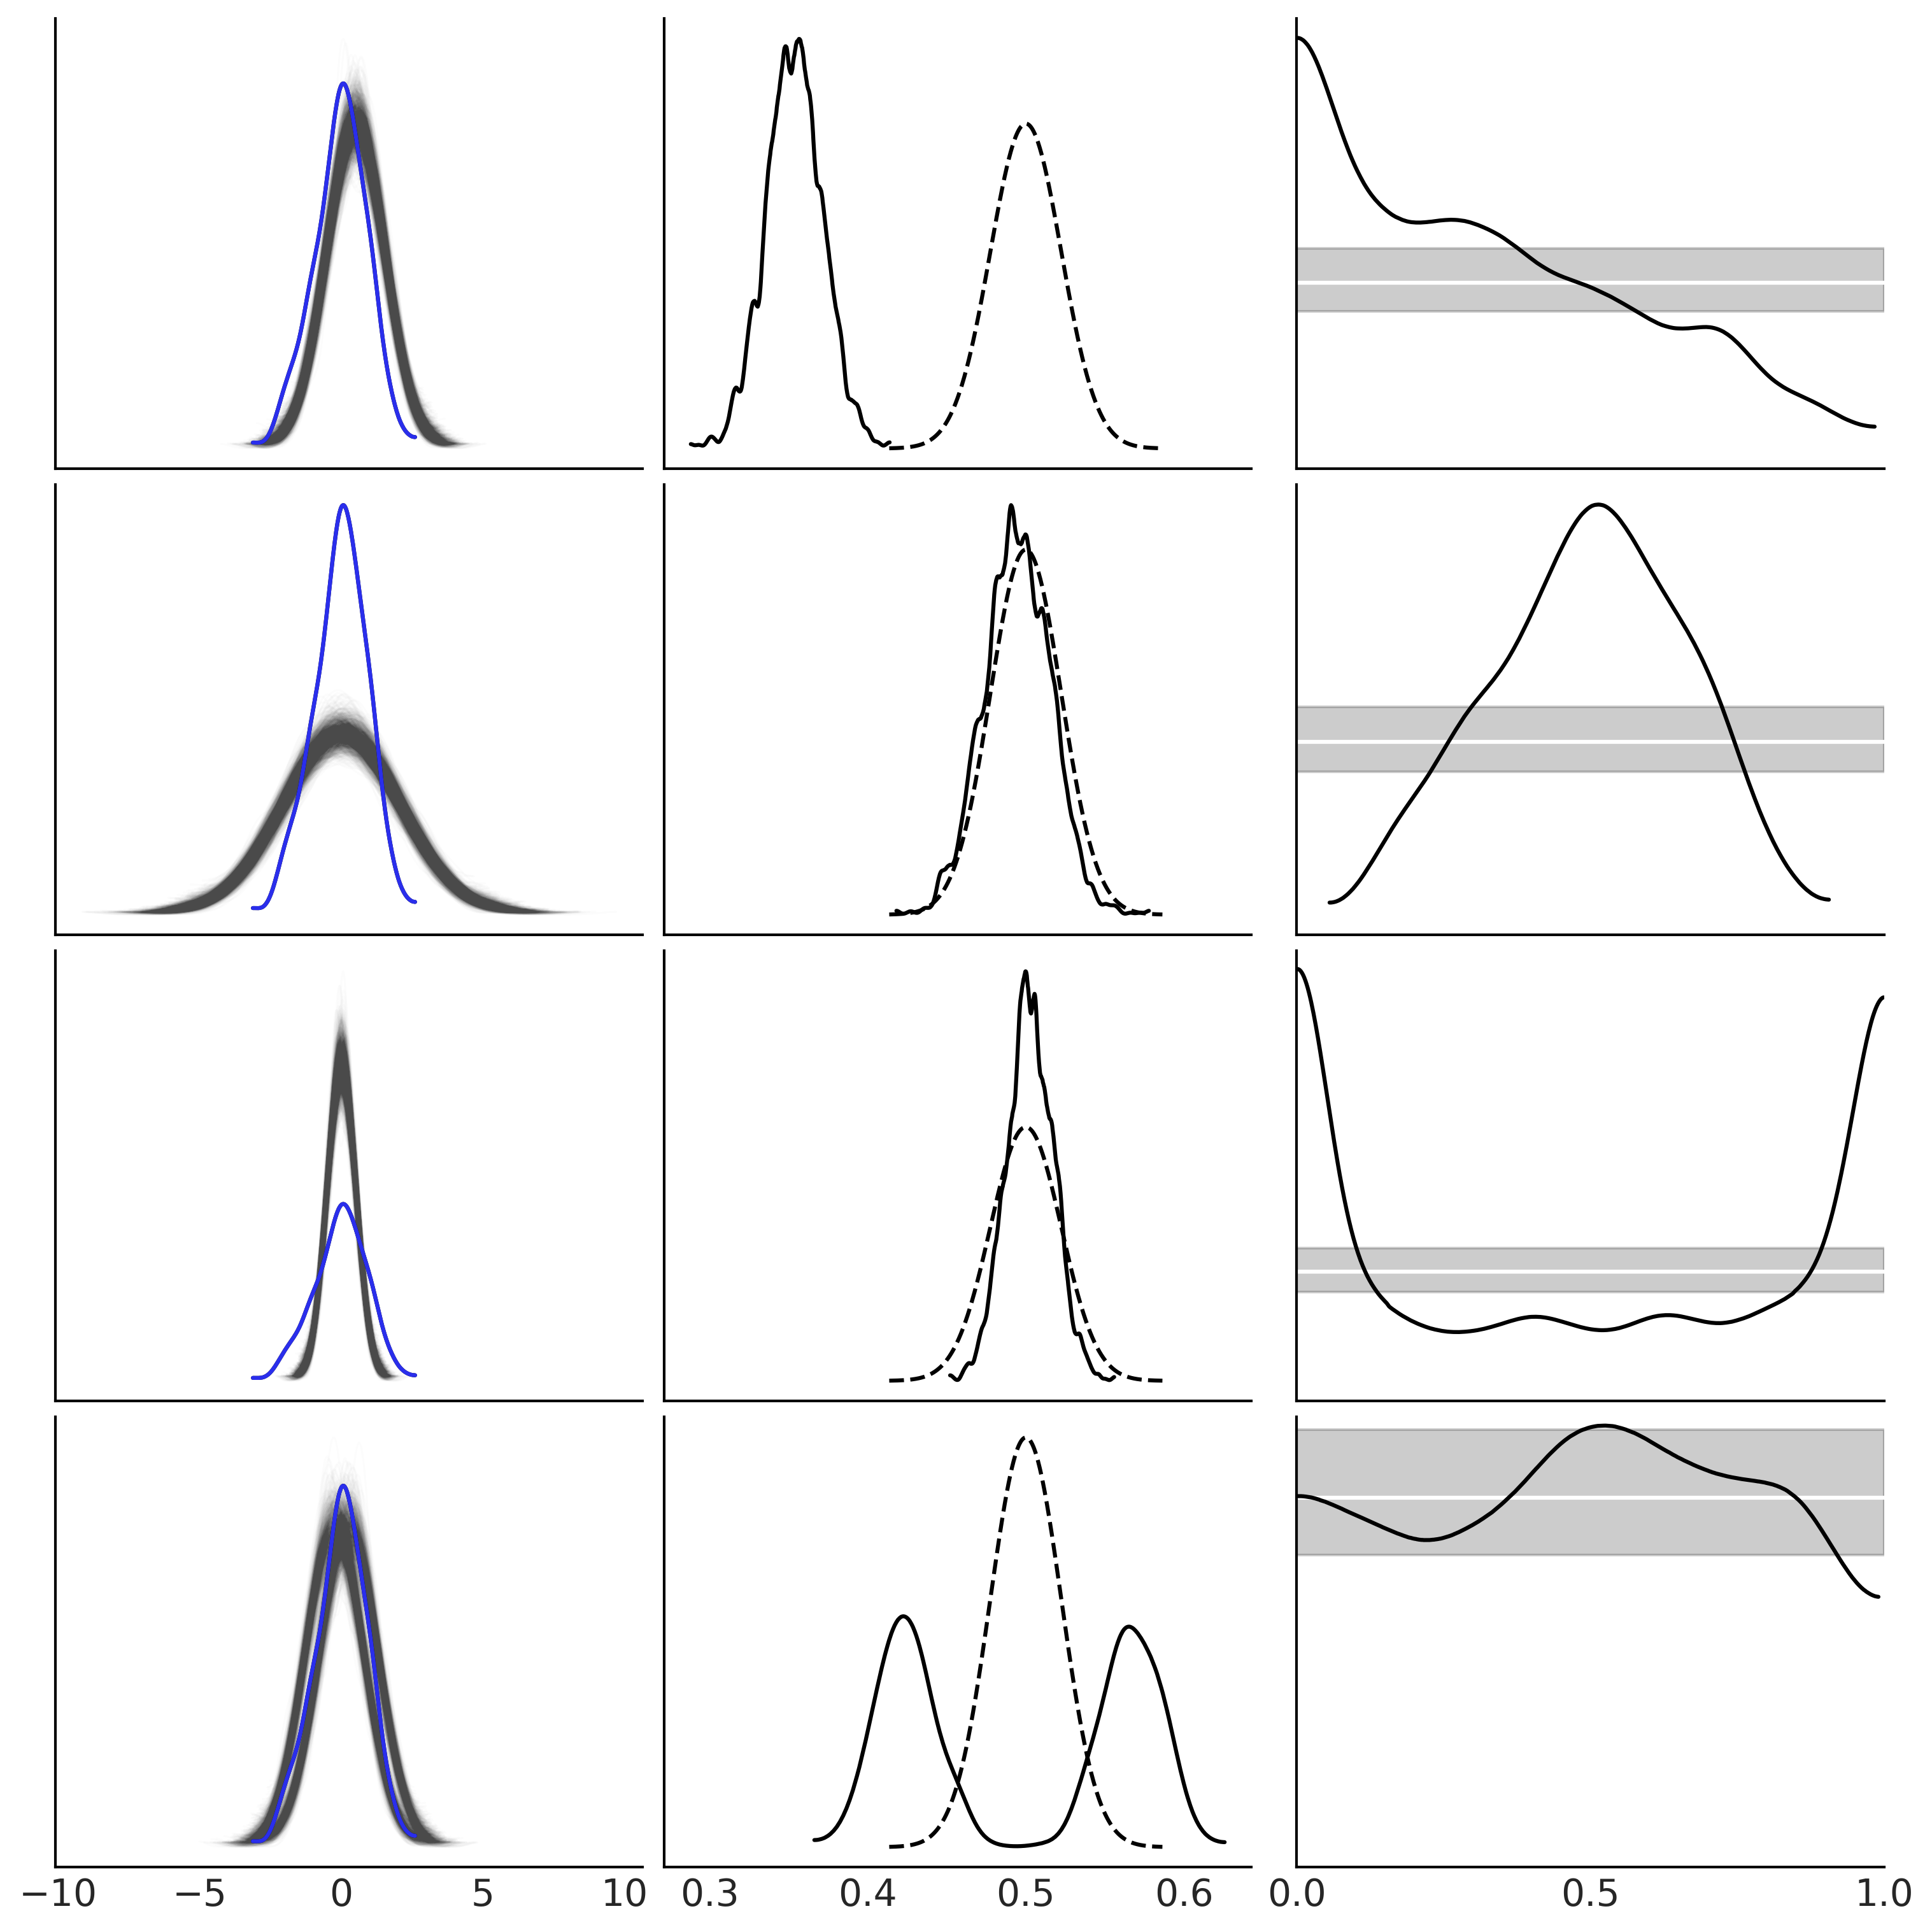

In [ ]:
_, axes = plt.subplots(len(idatas), 3, figsize=(10, 10), sharex="col")

for idata, ax in zip(idatas, axes):
    az.plot_ppc(idata, ax=ax[0], color="C1", alpha=0.01, mean=False, legend=False)
    az.plot_kde(idata.observed_data["y"].values, ax=ax[0], plot_kwargs={"color":"C4", "zorder":3})
    ax[0].set_xlabel("")
    az.plot_bpv(idata, kind="p_value", ax=ax[1])
    az.plot_bpv(idata, kind="u_value", ax=ax[2])
    ax[2].set_yticks([])
    ax[2].set_xticks([0., 0.5, 1.])
    for ax_ in ax:
        ax_.set_title("")

以上四个分布：    

1. 第一行的预测偏右    
2. 第二行的预测结果更离散
3. 第三行的预测结果更集中
4. 第四行的预测结果来自高斯混合分布

## 2.4. 数值诊断    
在本节中，我们将讨论马尔可夫链蒙特卡罗方法的最常见和最有用的诊断工具。    
    
为了演示我们创建人造的后验：    
        
第一个是`good_chains`来自 $\Beta(2, 5)$ ；    
第二个是 `bad_chains0` 代表不良的后验，通过对`good_chains`排序及增加小的高斯噪音产生：    

- 值之间不独立，相反它们是高度自相关的；
- 两组抽样不是一个分部，因为经历 reshape 和 重排序后，拆分为两部分。    

第三个是 `bad_chains1` 基于 `good_chains` 并随机在一些位置上插入一些来自同一分布的样本。这种场景很常见，代表一个采样器在一些参数空间表现很好，但是有一些区域很难采样到

In [48]:
good_chains = stats.beta.rvs(2, 5,size=(2, 2000))
bad_chains0 = np.random.normal(np.sort(good_chains, axis=None), 0.05,
                               size=4000).reshape(2, -1)

bad_chains1 = good_chains.copy()
for i in np.random.randint(1900, size=4):
    bad_chains1[i%2:,i:i+100] = np.random.beta(i, 950, size=100)

chains = {"good_chains":good_chains,
          "bad_chains0":bad_chains0,
          "bad_chains1":bad_chains1}

### 2.4.1. Effective Sample Size 
当使用 MCMC 方法时，我们需要足够的样本来估计后验分布。样本量是否充足不能直接由抽样次数觉得，因为 MCMC 有自相关性，所以其中包含的信息量会少于iid抽样结果。    
    
Effective Sample Size (ESS) 可以被理解为考虑了自相关性后换算为iid抽样的样本量。

In [49]:
az.ess(chains).data_vars

Data variables:
    good_chains  float64 3.845e+03
    bad_chains0  float64 2.443
    bad_chains1  float64 597.0

我们真实抽样次数为4000次，`good_chains` 与此结果很接近，`bad_chains1` 少了很多，`bad_chains0` 则更少。    
以上ess的算法为bulk即中心区域，可以切换为tail或quantile等。    
    
可视化可以更好的理解ESS在参数空间上的变化。可以用 `az.plot_ess(., kind="quantiles")` 或者 `az.plot_ess(., kind="local")`

/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


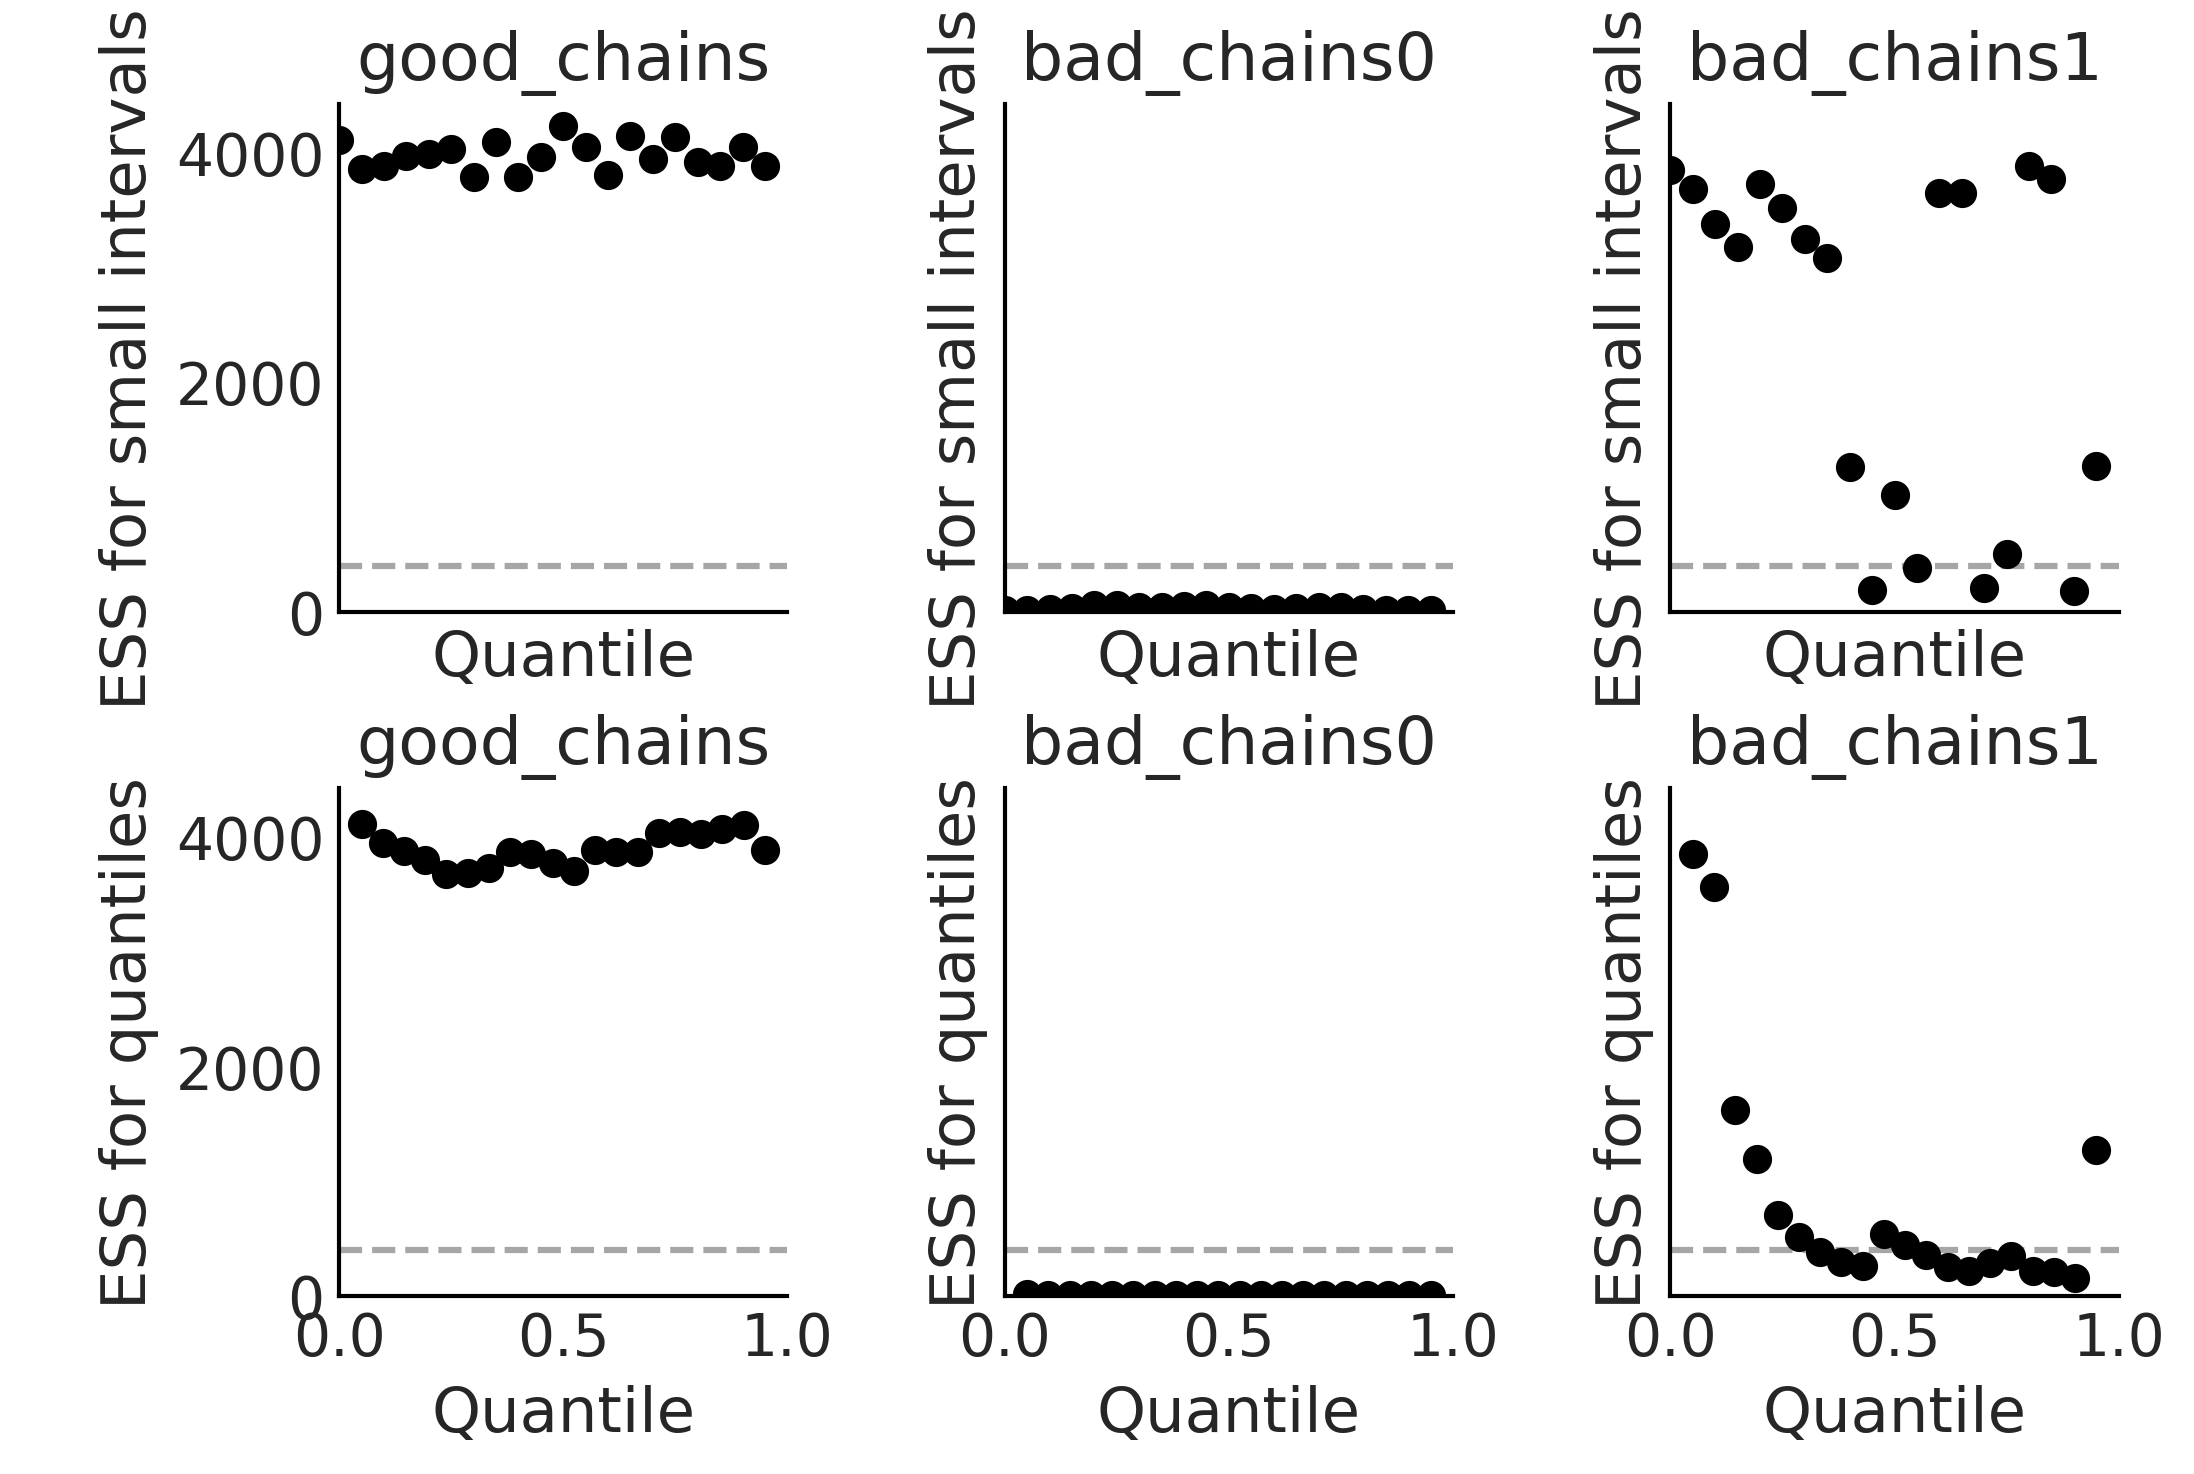

In [51]:
_, axes = plt.subplots(2, 3, sharey=True, sharex=True)
az.plot_ess(chains, kind="local", ax=axes[0]);
az.plot_ess(chains, kind="quantile", ax=axes[1]);

一般认为 ESS 值要大于400，否则评估结果基本是不靠谱的。    

### 2.4.2. Potential Scale Reduction Factor $\hat{R}$

在一般条件下有理论可证明，无论马尔科夫蒙特卡洛方法的起点为哪里都会得到相同的结果。然而这是在无限抽样的情况下，现实中我们只能有限抽样因此需要校验其收敛性。
一种校验方法是从不同起点执行多个 MCMC 链看几个链是否相似。$\hat{R}$ 就是这种诊断方法的结果。    
$\hat{R}$ 被解释为 MCMC 有限抽样造成的方差高估，因此成为 “potential scale reduction factor(PSRF)” 。 $\hat{R} = 1$ 意味着增加样本量不会再降低结果的方差。然而在实践中，最好将其视为一种诊断工具，而不要过度解释它。     
     

> [**计算方法**](http://staff.ustc.edu.cn/~zwp/teach/Stat-Comp/Lec9.pdf)     
假设有 k 个链，每个链有 n 个样本，感兴趣的量为 $\phi$，其在目标分布下有期望 $\mu$ 和 方差 $\sigma ^ 2$。    
记 $\phi_{jt}$ 为链 j 的第 t 个样本 $\phi$ 的值，那么混合样本中，$\mu$ 的无偏估计为 $\mu = \bar{\phi}$ 。链之间的方差 B/n 和链内的方差 W 分别为：
> $$B/n = \frac{1}{k-1} \sum_{j = 1}^{k}(\bar{\phi_j} - \bar{\phi})^2 $$
> $$W = \frac{1}{k(n-1)}\sum_{j = 1}^{k}\sum_{t=1}^{n}(\phi_{jt} - \bar{\phi}_j) ^ 2$$
> 从而可以通过 B 和 W 加权估计 $\sigma ^ 2$：
> $$\hat{\sigma}_{+} ^ 2 = \frac{n - 1}{n}W + \frac{B}{n}$$
> 如果初始值是从目标分布中抽取的，$\hat{\sigma}_+^2$就是$\sigma$的无偏估计。但是如过渡分散则会高估。考虑估计量$\hat{\mu}$的抽样波动，方差的估计值为$\hat{V} = \hat{\sigma}^2_+ + \frac{B}{kn}$    
> 比较混合和链内的推断可以通过： 
> $$R = \frac{\hat{V}}{\sigma ^ 2}$$
> 称 $\sqrt{R}$ 为 scale reduction factor(SRF) ，其估计值 potential scale reduction factor(PSRF) 为 
> $$\hat{R} = \frac{\hat{V}}{W}$$

理论上 $\hat{R}$ 应该为1，但是实际中会有一些误差。一般认为 $\hat{R} < 1.1$ 时可以认为收敛。    

In [54]:
az.rhat(chains).data_vars

Data variables:
    good_chains  float64 1.0
    bad_chains0  float64 2.392
    bad_chains1  float64 1.023

以上结果说明 `good_chains` 收敛很好，`bad_chains0` 收敛很差，`bad_chains1` 稍微好一些但是仍然不符合标准。

### 2.4.3. 蒙特卡洛标准误

由于通过有限样本的 MCMC 来逼近后验，这引入了额外的不确定性。我们通过 Monte Carlo standard error (MCSE) 来评估引入的不确定性大小。    
如果我们评估参数的值精确度要到小数点后两位，则需要 MCSE 低于小数点后两位。  
当然 MCSE 仅在 ESS 足够高且 $\hat{R}$ 足够小时才有意义。

In [56]:
az.mcse(chains).data_vars

Data variables:
    good_chains  float64 0.002561
    bad_chains0  float64 0.107
    bad_chains1  float64 0.00688

与 ESS 一样，MCSE 在参数空间中变化，可能需要在不同区间（比如分位点）评估。我们可以进行可视化：

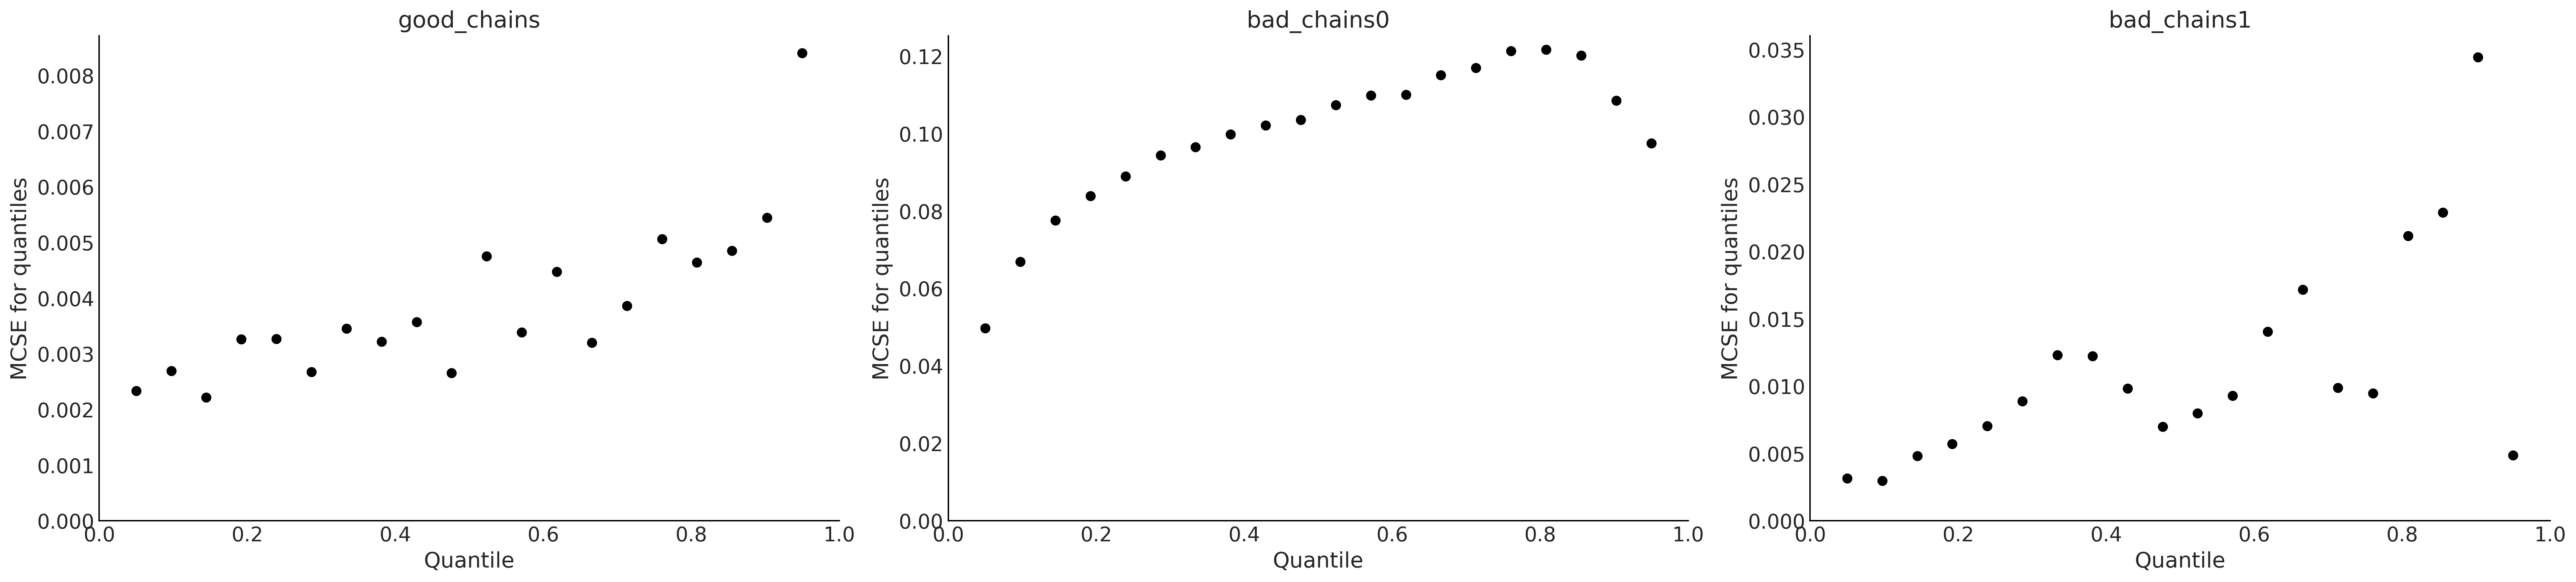

In [58]:
az.plot_mcse(chains);

ESS ，$\hat{R}$ 和 MCSE 可以通过 `az.summary(.)` 一起计算：

In [59]:
az.summary(chains, kind="diagnostics")

mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
good_chains      0.003    0.002    3845.0    3883.0   1.00
bad_chains0      0.107    0.087       2.0      11.0   2.39
bad_chains1      0.007    0.005     597.0    1268.0   1.02

### 2.4.4. Trace Plots

Trace Plots 可能是最常用的分析方法。从中我们可以观察到不同 chains 是否收敛到相似分布。

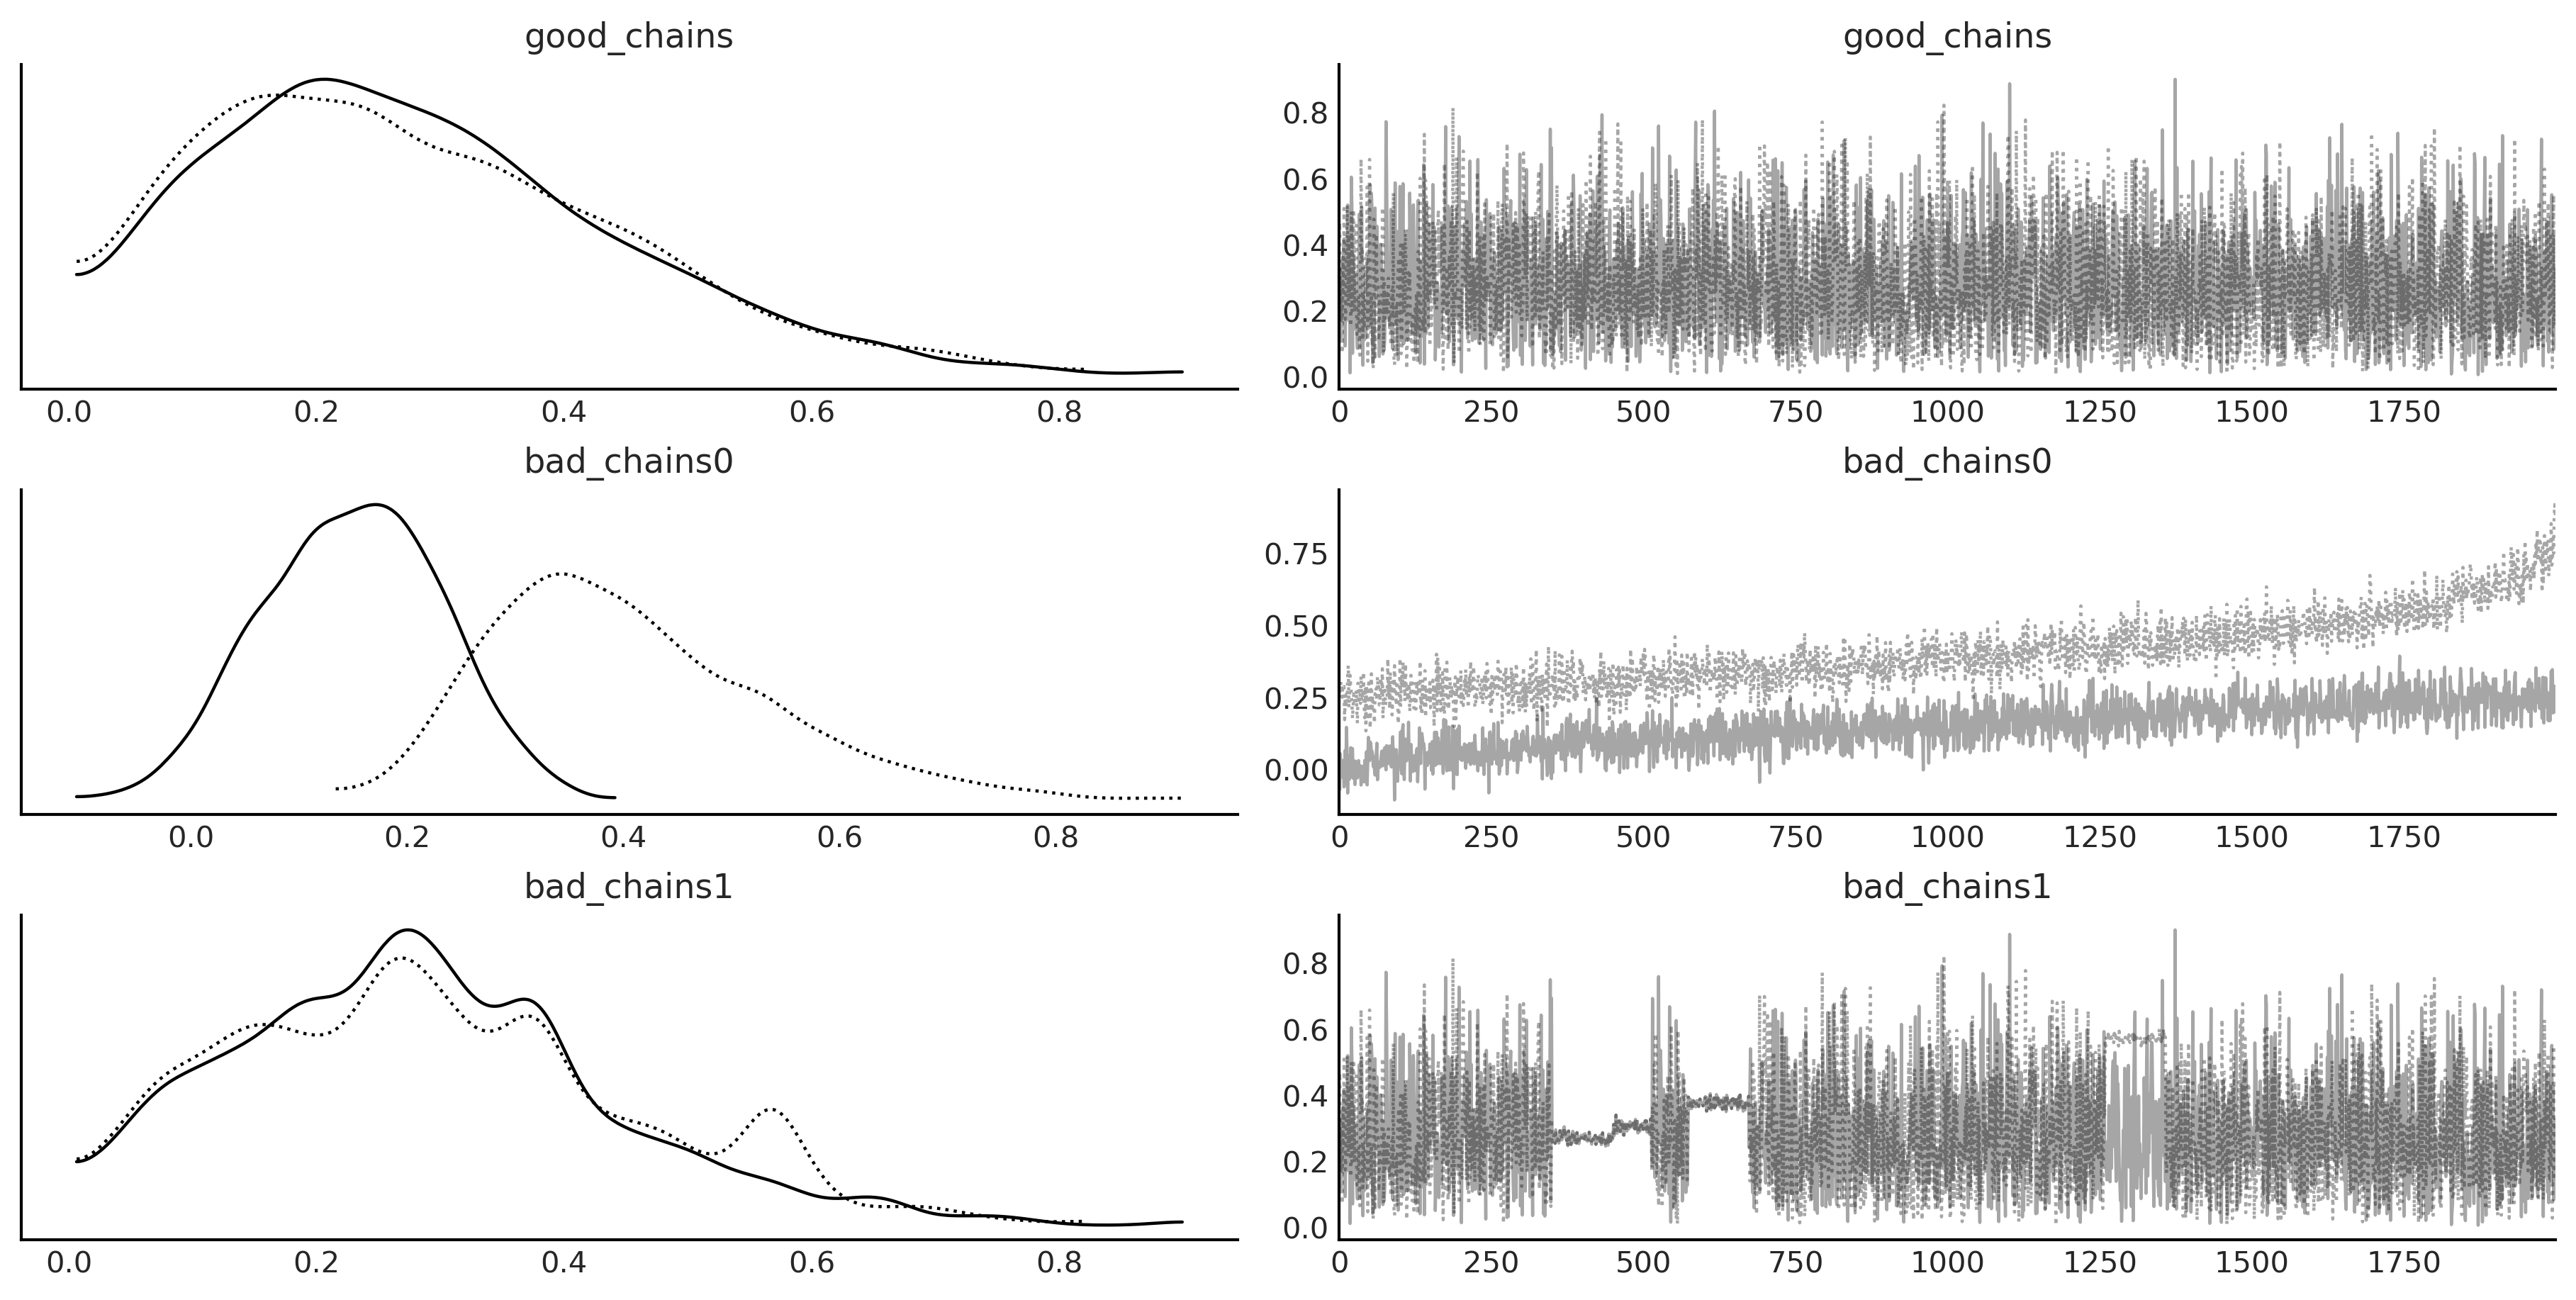

In [63]:
az.plot_trace(chains);

### 2.4.5. Autocorrelation Plots
自相关性是导致 MCMC 结果信息量不足的主要原因。我们可以通过自相关图来观察自相关性。

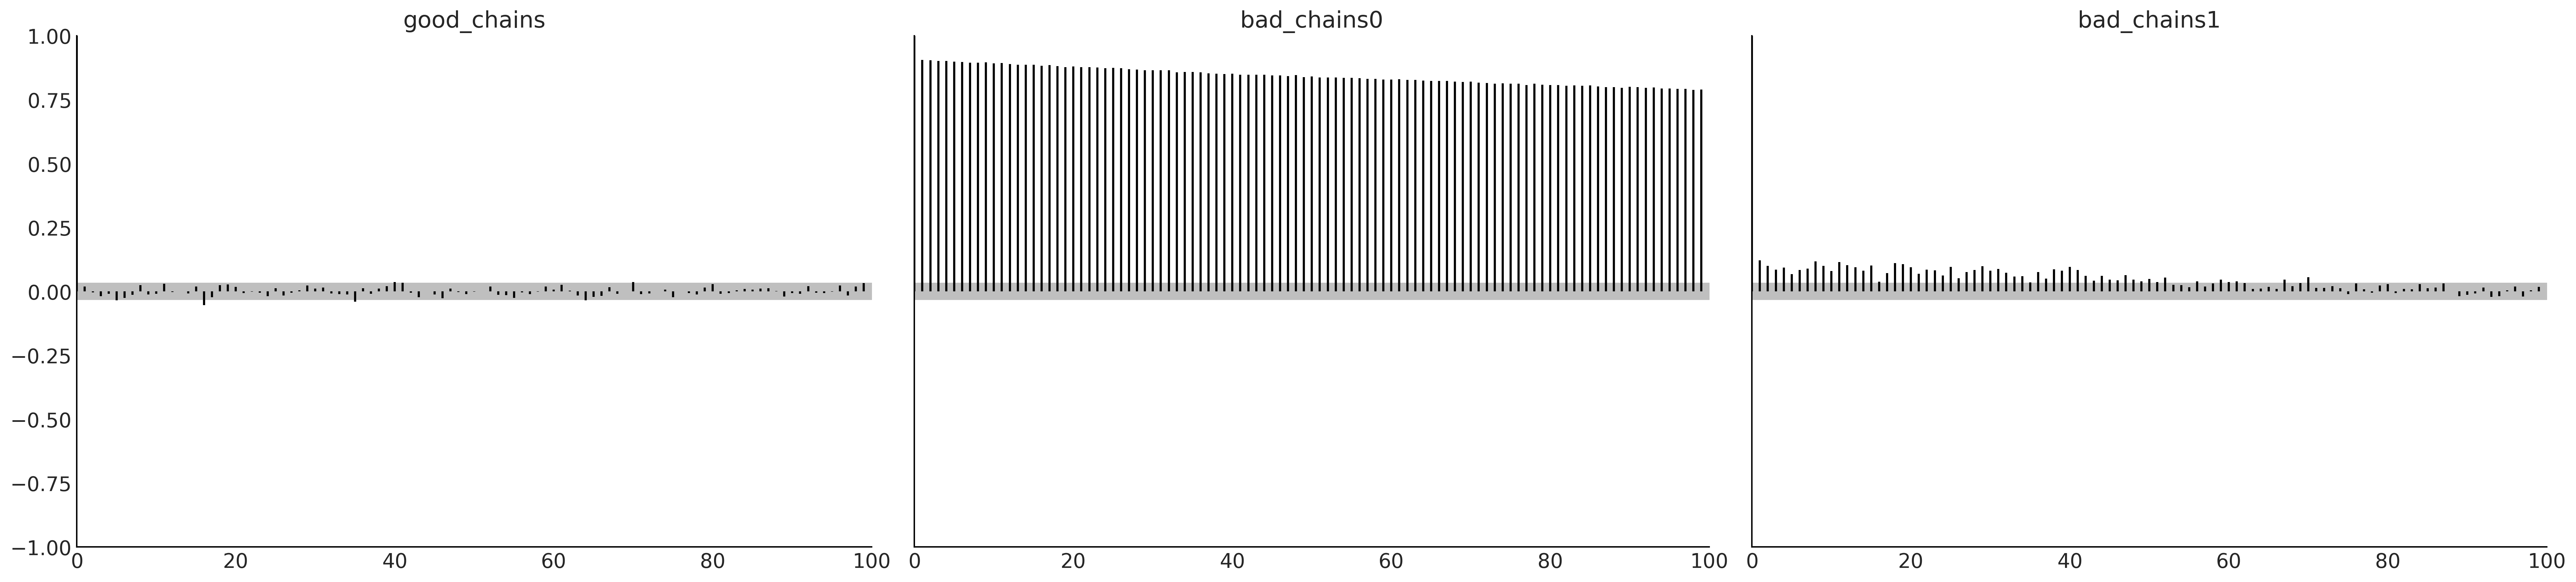

In [68]:
az.plot_autocorr(chains, combined=True);

### 2.4.6. Rank Plots
Rank Plots是另一种常见诊断方法。它先将所有链混合排序，在分别绘制各个链的rank分布。如果所有链都是从同一分布中抽取的，那么rank分布应该是相似的，并且为均匀分布。

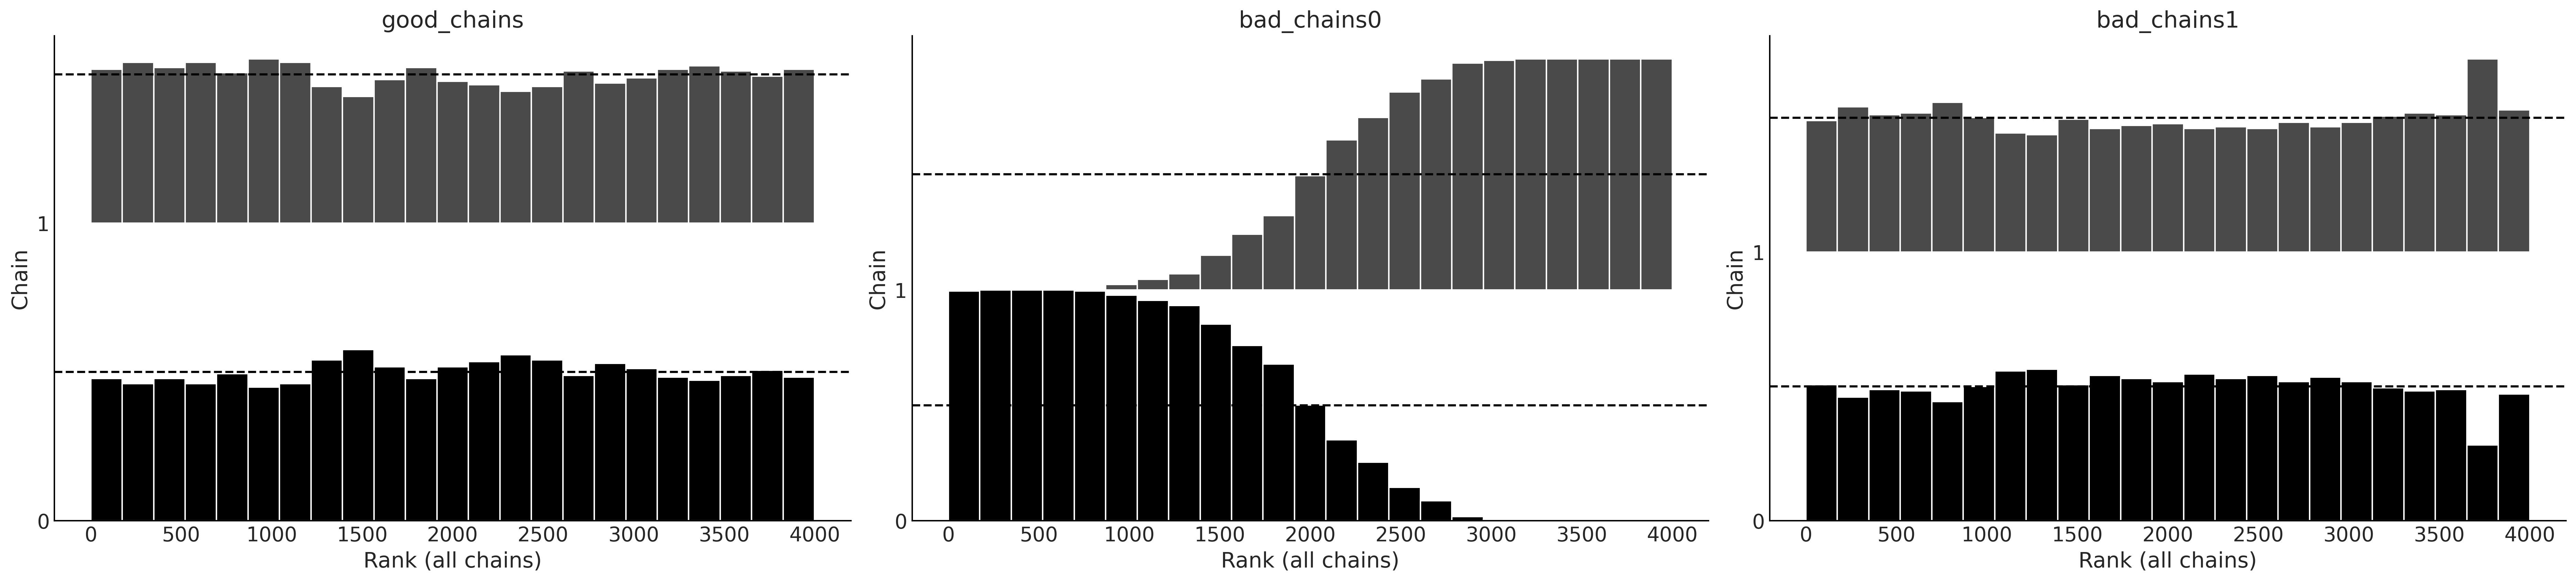

In [72]:
az.plot_rank(chains, kind="bars");

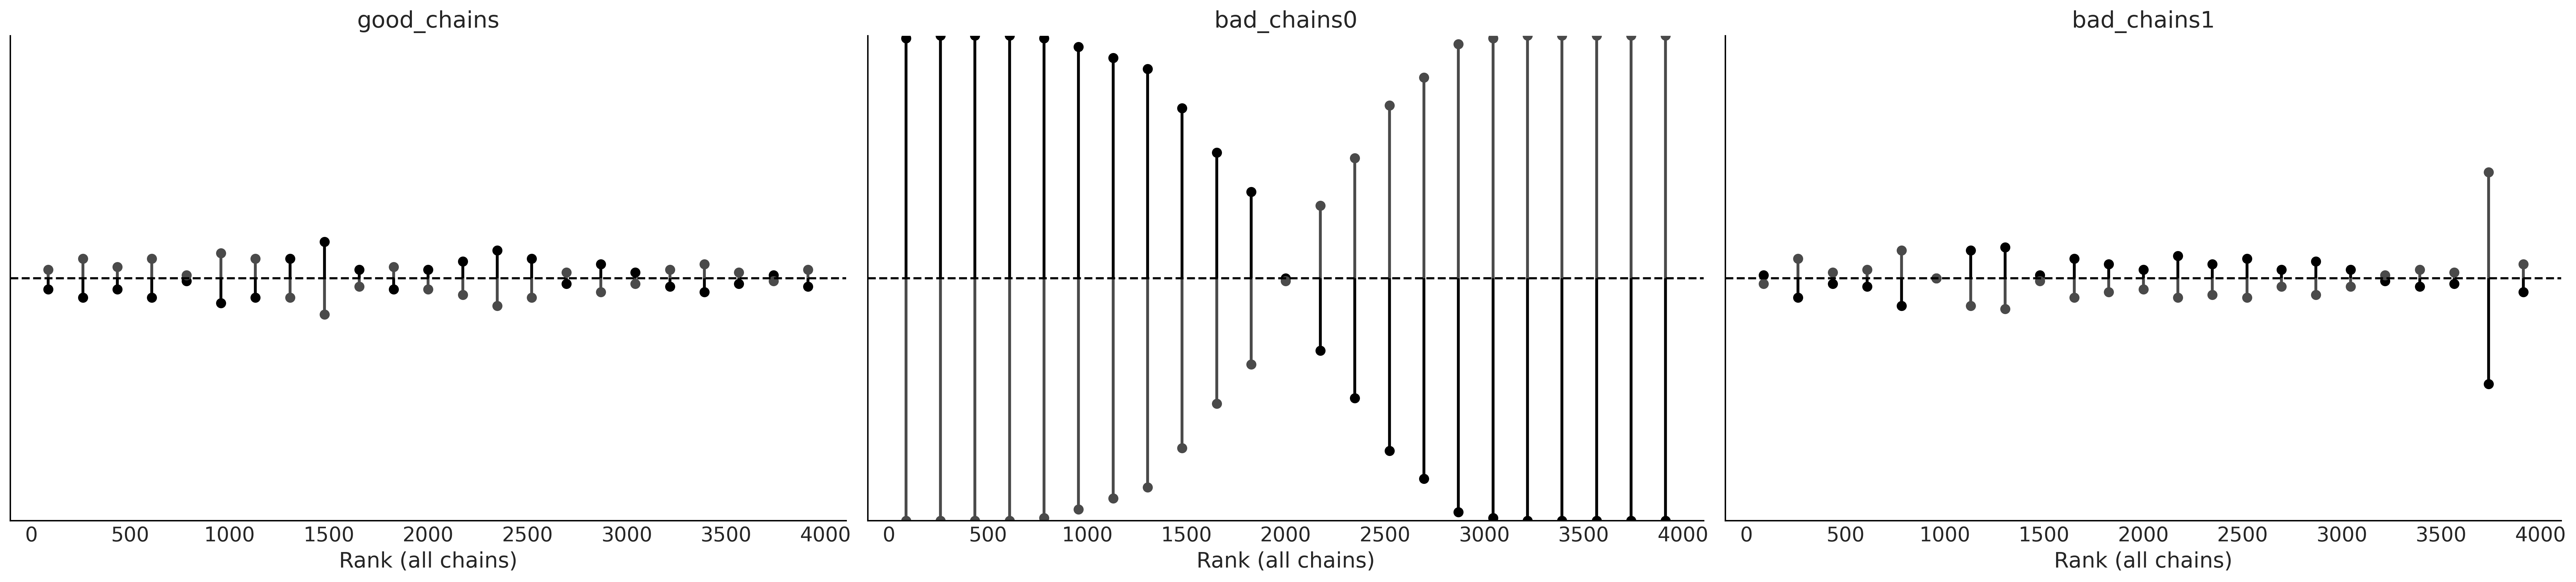

In [77]:
az.plot_rank(chains, kind="vlines");

Rank Plots 可能比  Trace Plots 更敏感。可以将它们一起绘制

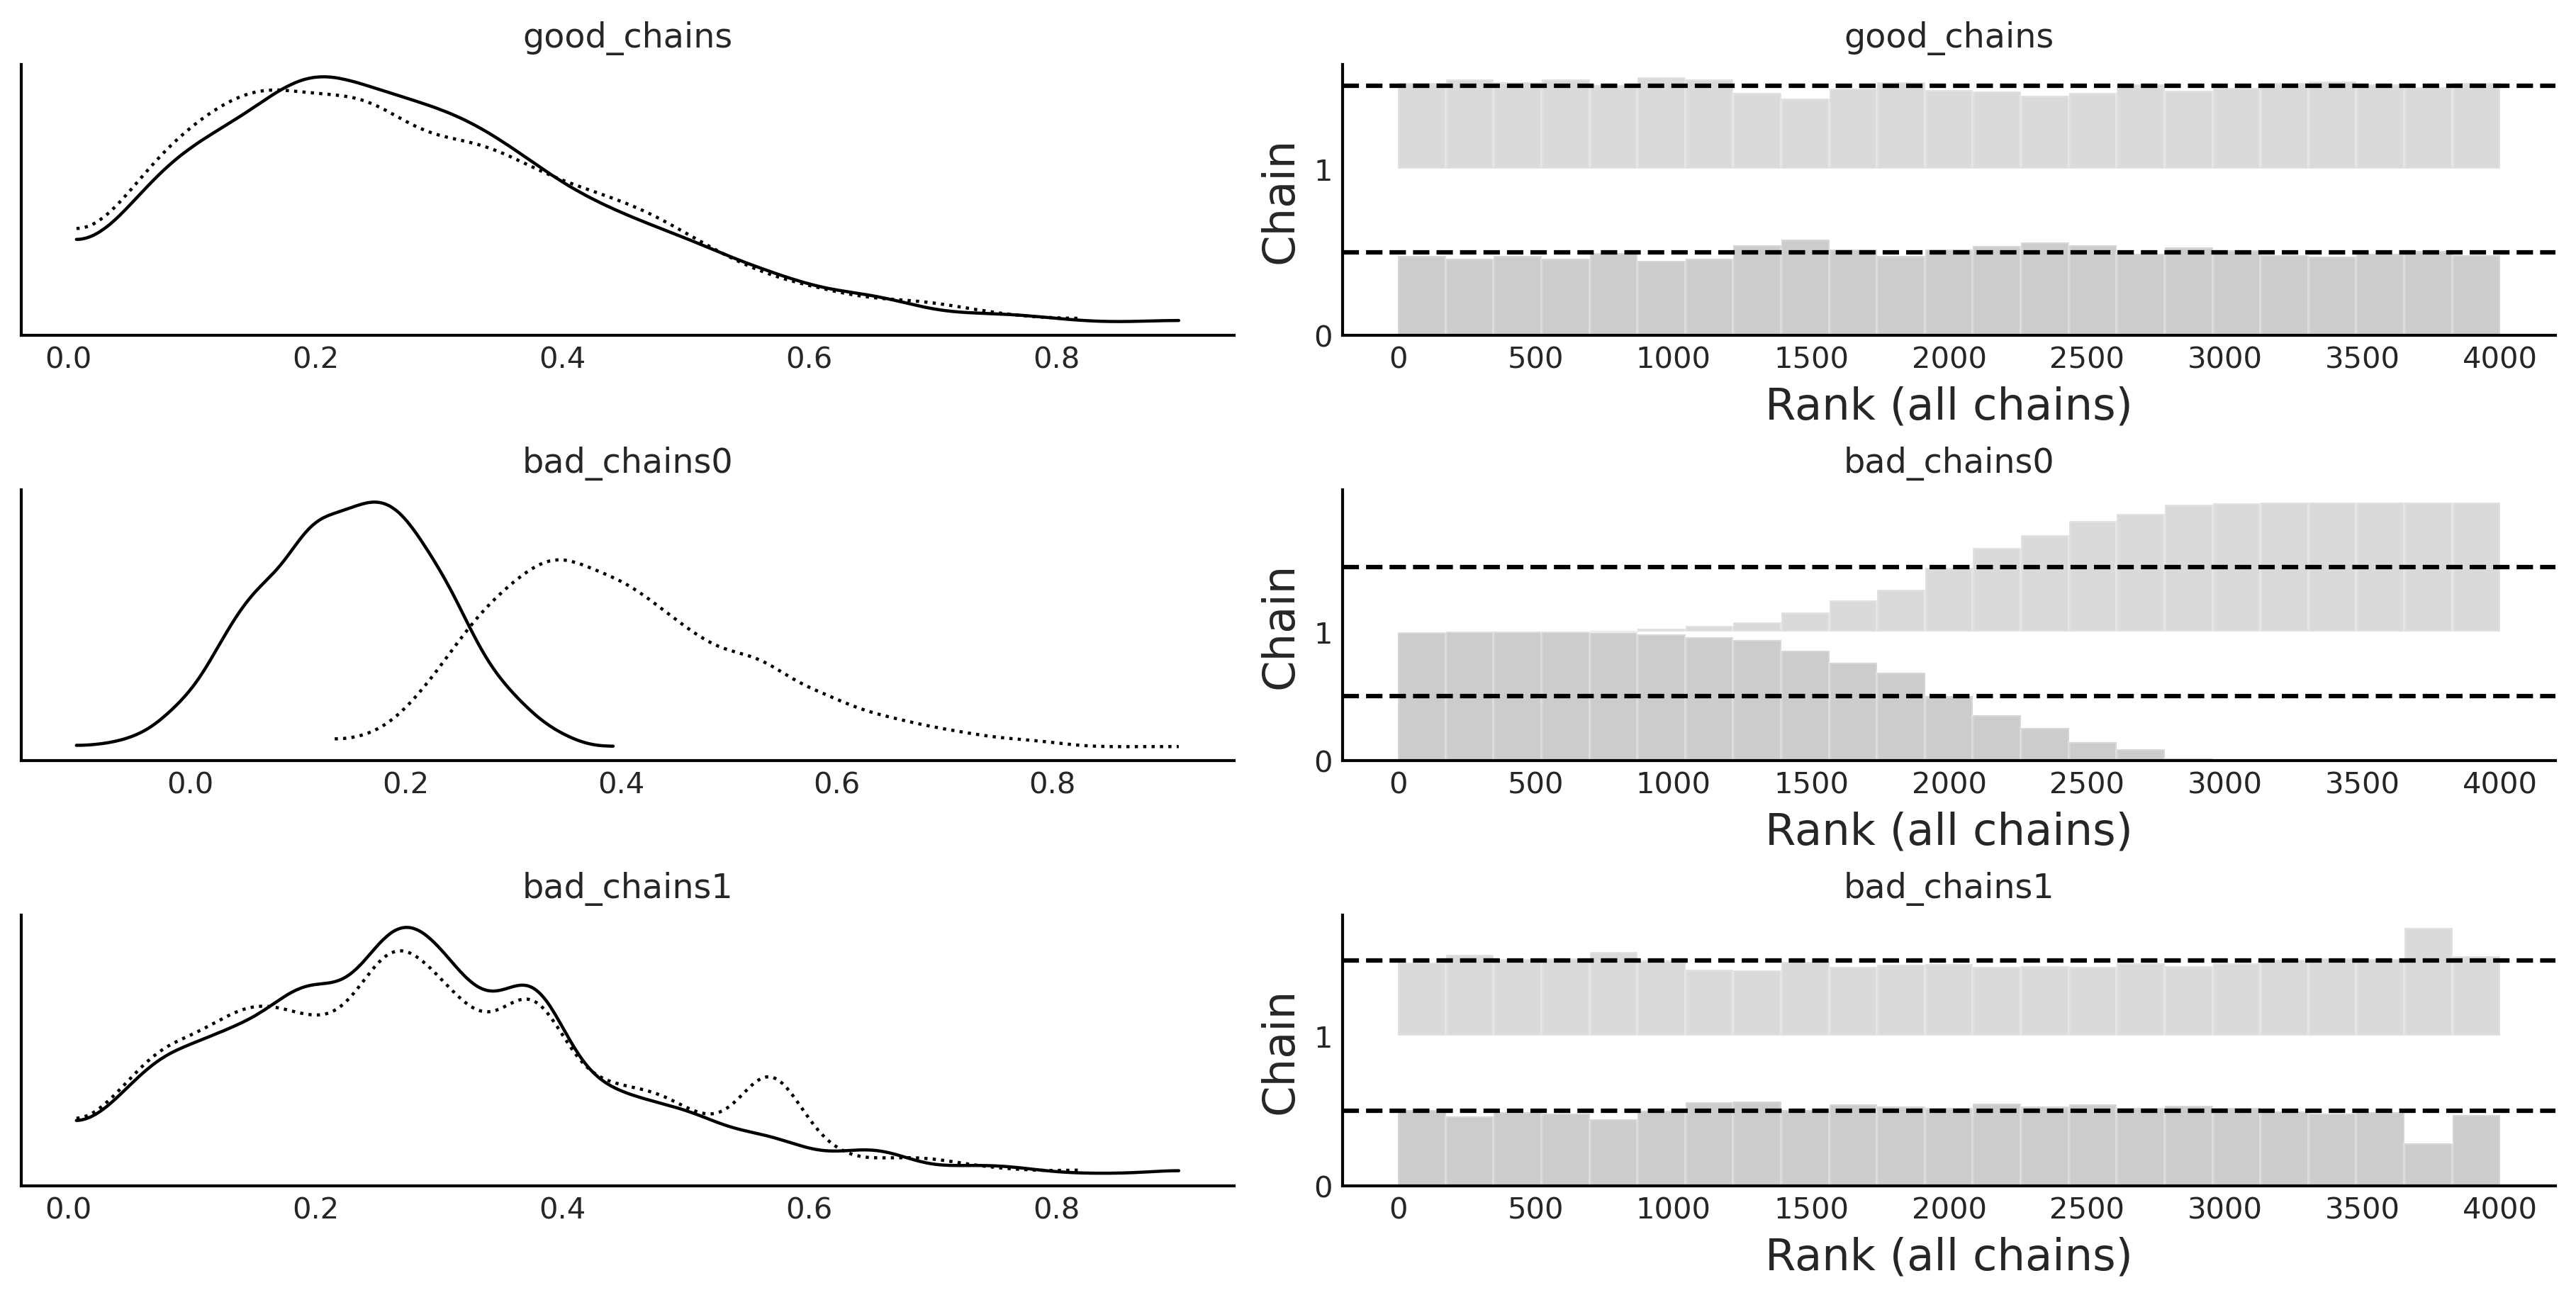

In [80]:
az.plot_trace(chains, kind="rank_bars");

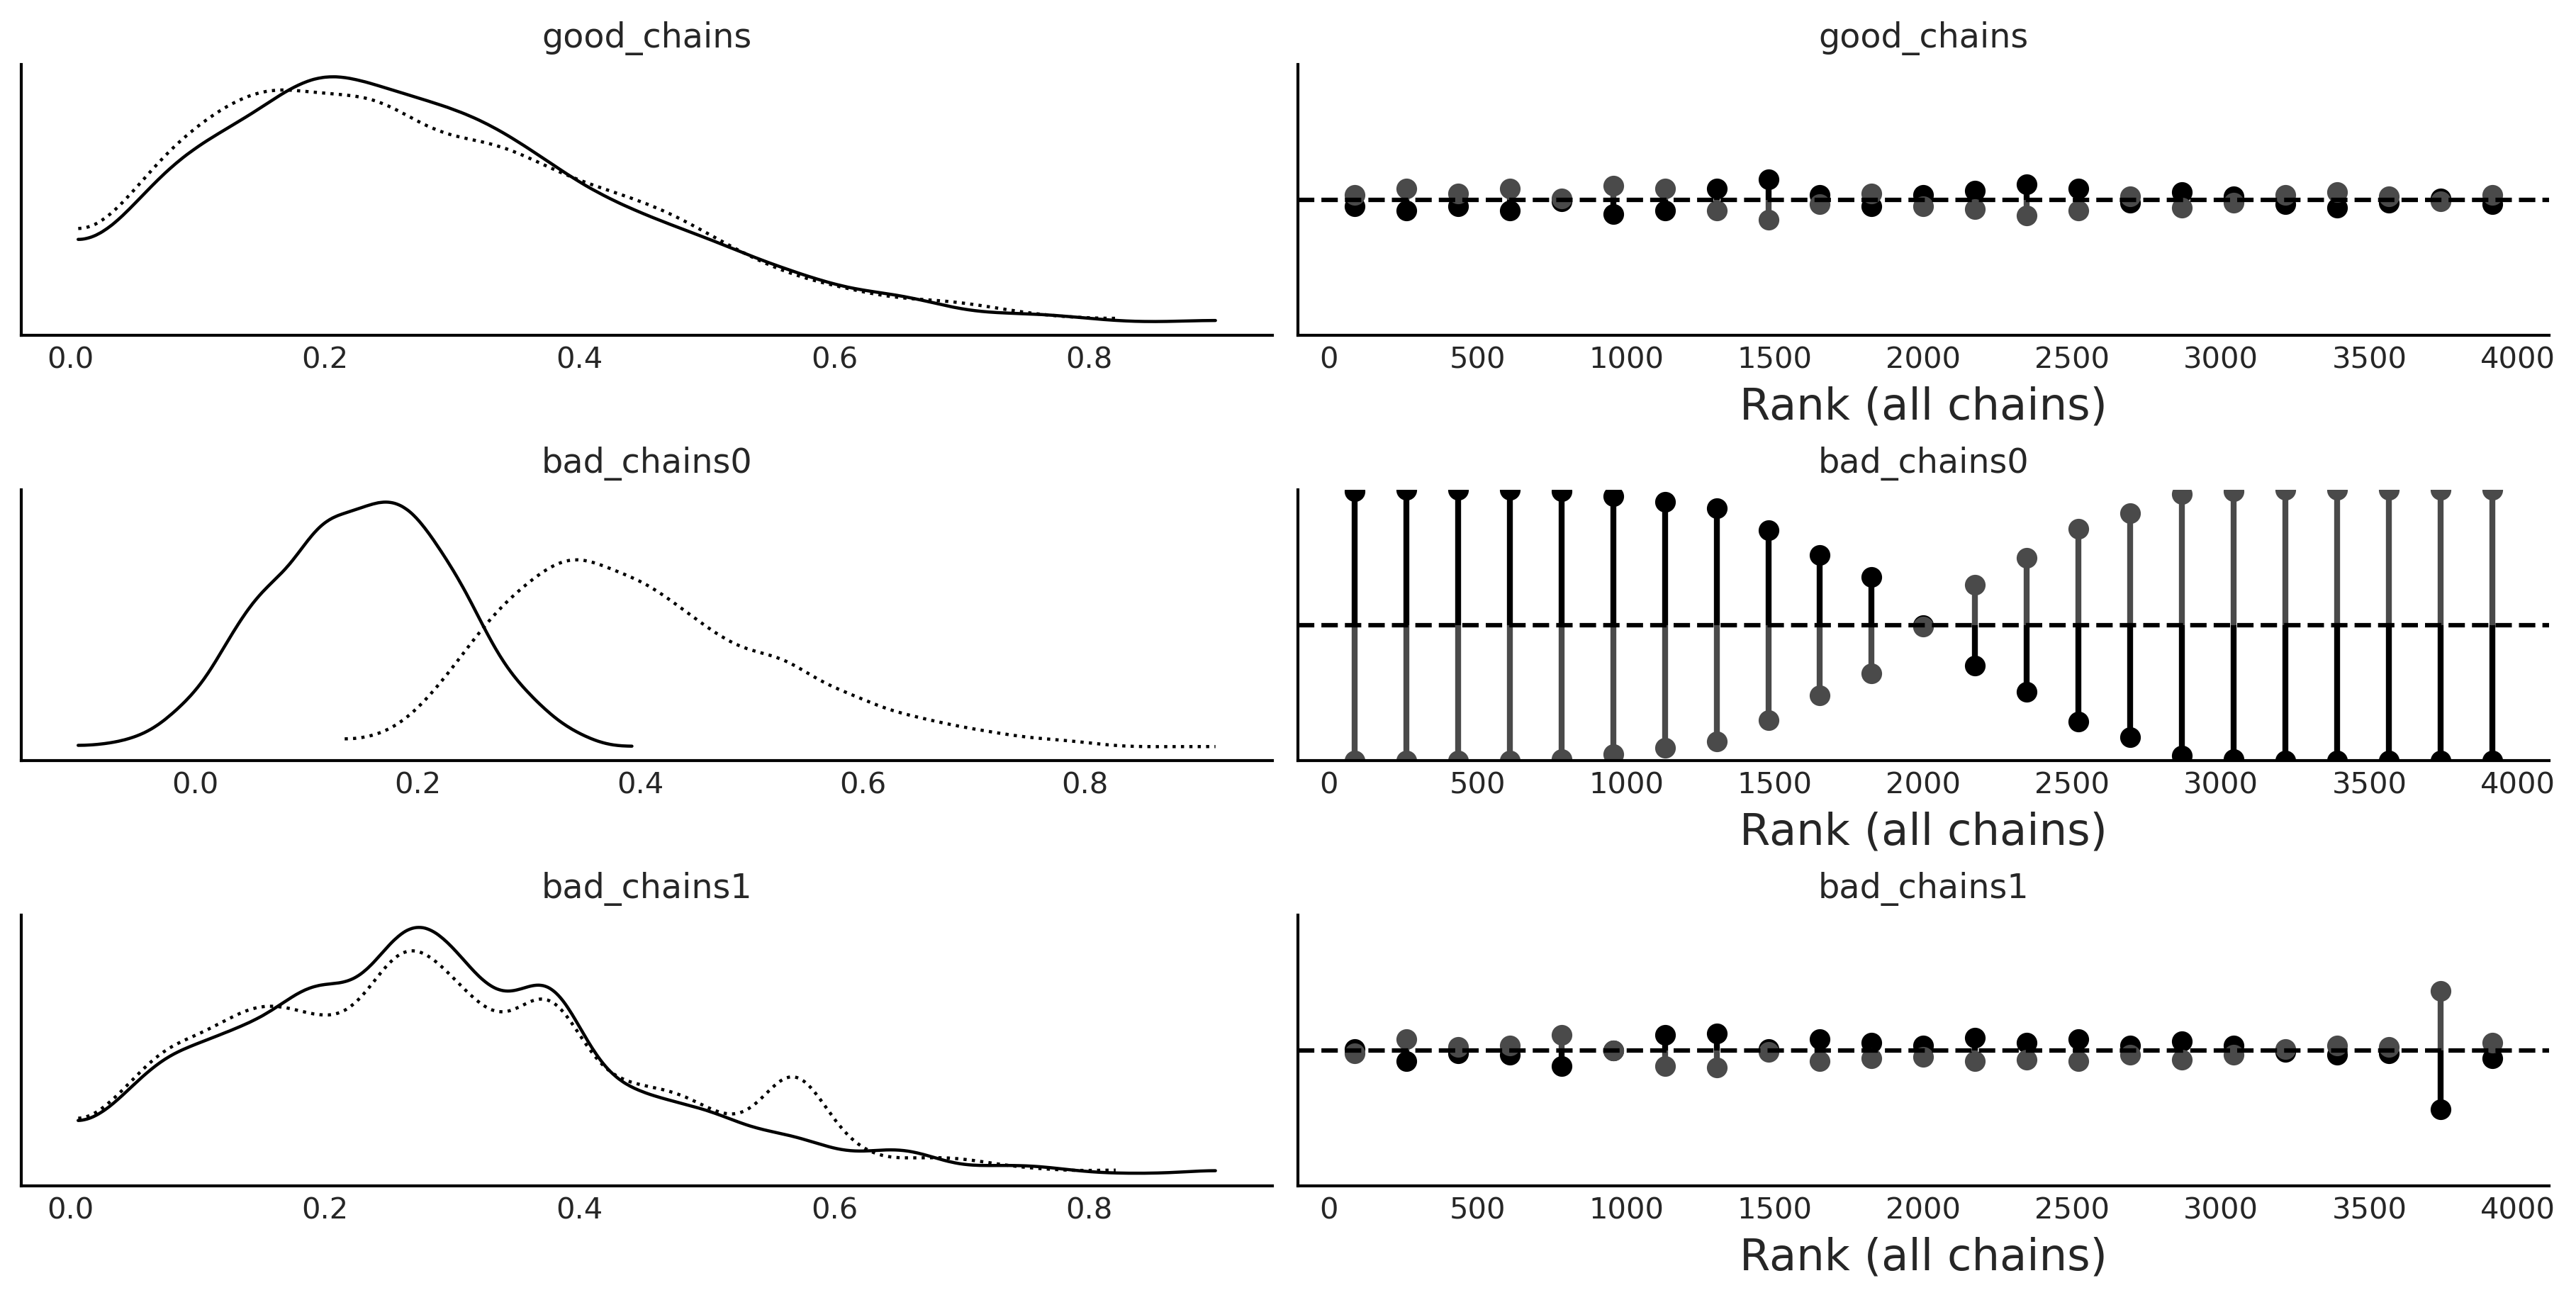

In [81]:
az.plot_trace(chains, kind="rank_vlines");

### 2.4.7. Divergences（散度）
以上都是基于 MCMC 生成的样本进行诊断。另一种诊断方法是监控抽样过程。    
其中一个典型的例子是 Hamiltonian Monte Carlo (HMC) 中的Divergences，它是一种强大且敏感的方法，可以作为前面方法的补充。    
    
以下是一个示例

- model_0：$\theta_2$ 服从 $[-\theta_1, \theta_1]$的均匀分布，而 $\theta_1$ 来自一个正态分布
- model_1：$\theta_2$ 服从 $[-\theta_1, \theta_1]$的均匀分布，而 $\theta_1$ 来自一个半正态分布
- model_2：$\theta_2$ 服从 $[-\theta_1, \theta_1]$的均匀分布，而 $\theta_1$ 来自一个正态分布

In [83]:
with pm.Model() as model_0:
    theta_1 = pm.Normal("theta_1", 0, 1, initval=0.1)
    theta_2 = pm.Uniform("theta_2", -theta_1, theta_1)
    idata_0 = pm.sample(return_inferencedata=True)

with pm.Model() as model_1:
    theta_1 = pm.HalfNormal("theta_1",1 / (2/np.pi)**0.5)
    theta_2 = pm.Uniform("theta_2", -theta_1, theta_1)
    idata_1 = pm.sample(return_inferencedata=True)

with pm.Model() as model_1bis:
    theta_1 = pm.HalfNormal("theta_1",1 / (2/np.pi)**0.5)
    theta_2 = pm.Uniform("theta_2", -theta_1, theta_1)
    idata_1bis = pm.sample(return_inferencedata=True, target_accept=0.95)

idatas = [idata_0, idata_1, idata_1bis]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_1, theta_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There were 2202 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_1, theta_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_1, theta_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


Text(0.45, 0.33, 'model 1bis')

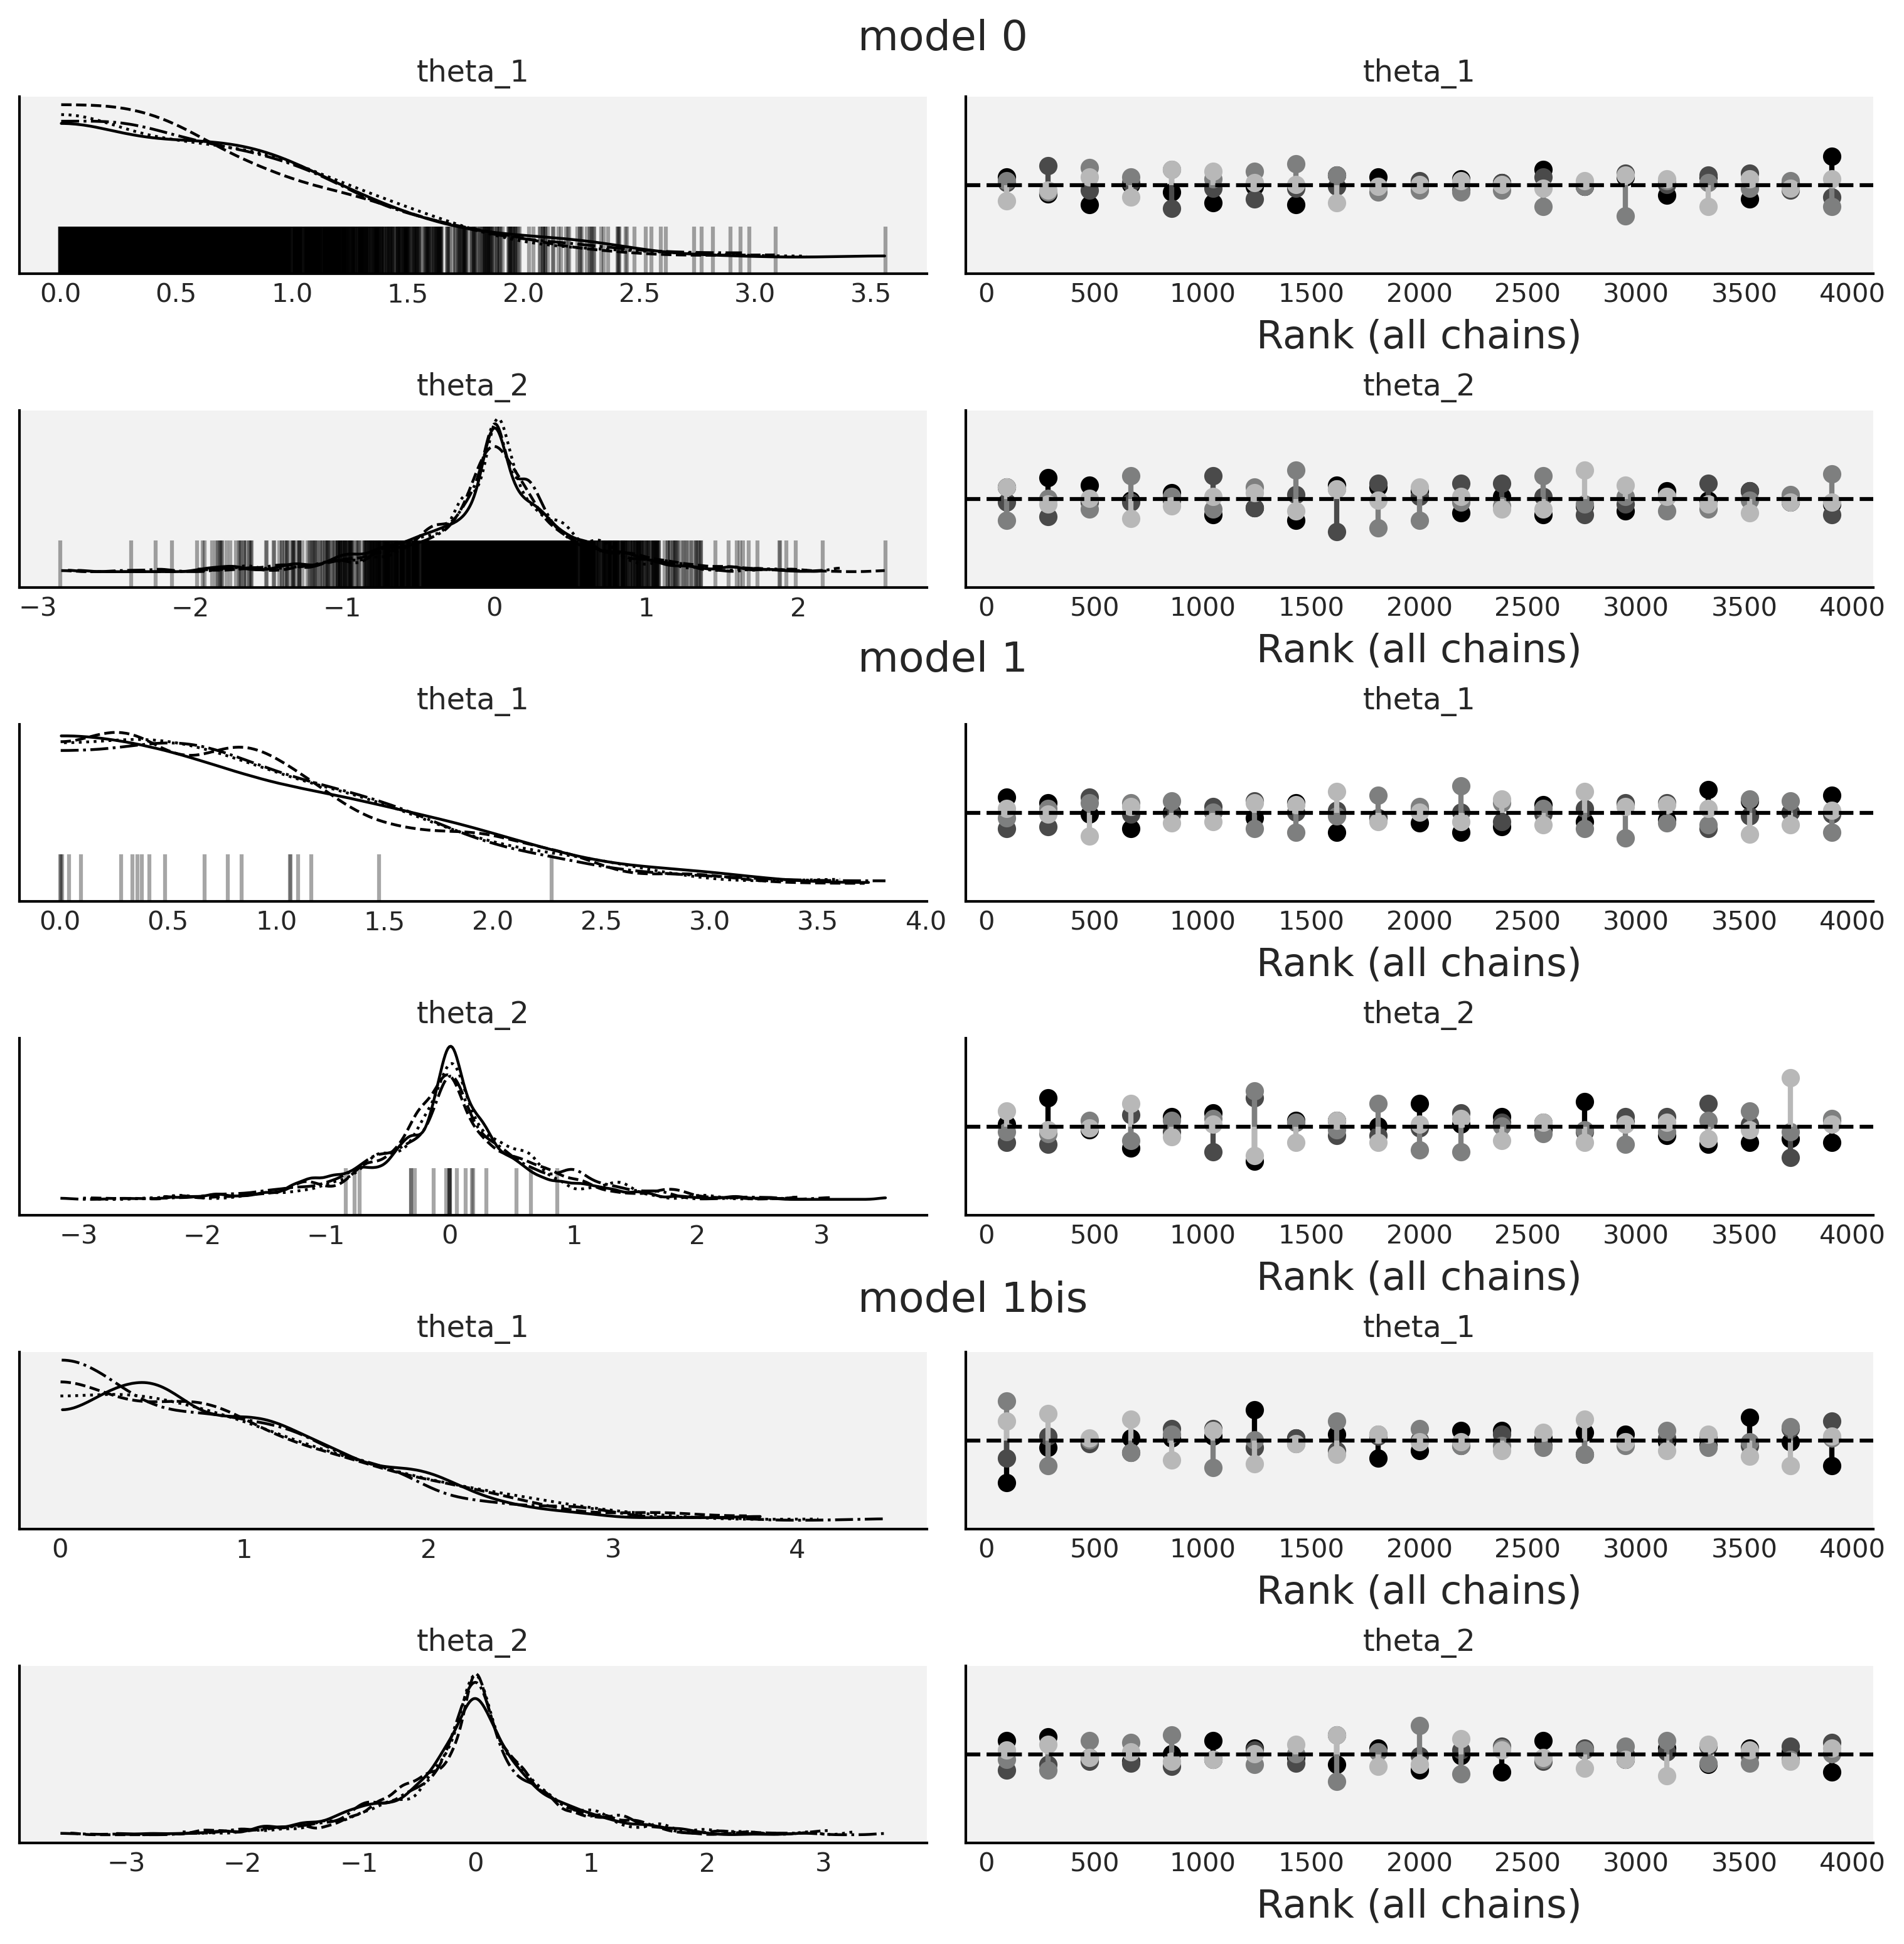

In [84]:
fig, axes = plt.subplots(6, 2, figsize=(10, 10))

axes = axes.reshape(3, 2, 2)
for idata, ax, color in zip(idatas, axes, ["0.95", "1", "0.95"]):
    az.plot_trace(idata, kind="rank_vlines", axes=ax);
    [ax_.set_facecolor(color) for ax_ in ax.ravel()]
fig.text(0.45, 1, s="model 0", fontsize=16)
fig.text(0.45, 0.67, s="model 1", fontsize=16)
fig.text(0.45, 0.33, s="model 1bis", fontsize=16)

以上在KDEs图中可以看到底部的黑线，每个黑线代表一次divergence，说明抽样中产生了问题。    

- model_0：有很多divergence，这是因为我们先验选择了正态分布，会出现 $-\theta_1 > \theta_1$ 的情况； 
- model_1：divergence少了很多，因为我们先验选择了半正态分布，不会出现 $-\theta_1 > \theta_1$ 的情况；
- model_2：基于model_1，将 `target_accept` 从默认的0.8改为0.95，消除了所有divergence。    
    
我们也可以用散点图来观察divergence：

/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


Text(0.5, 0, 'θ1')

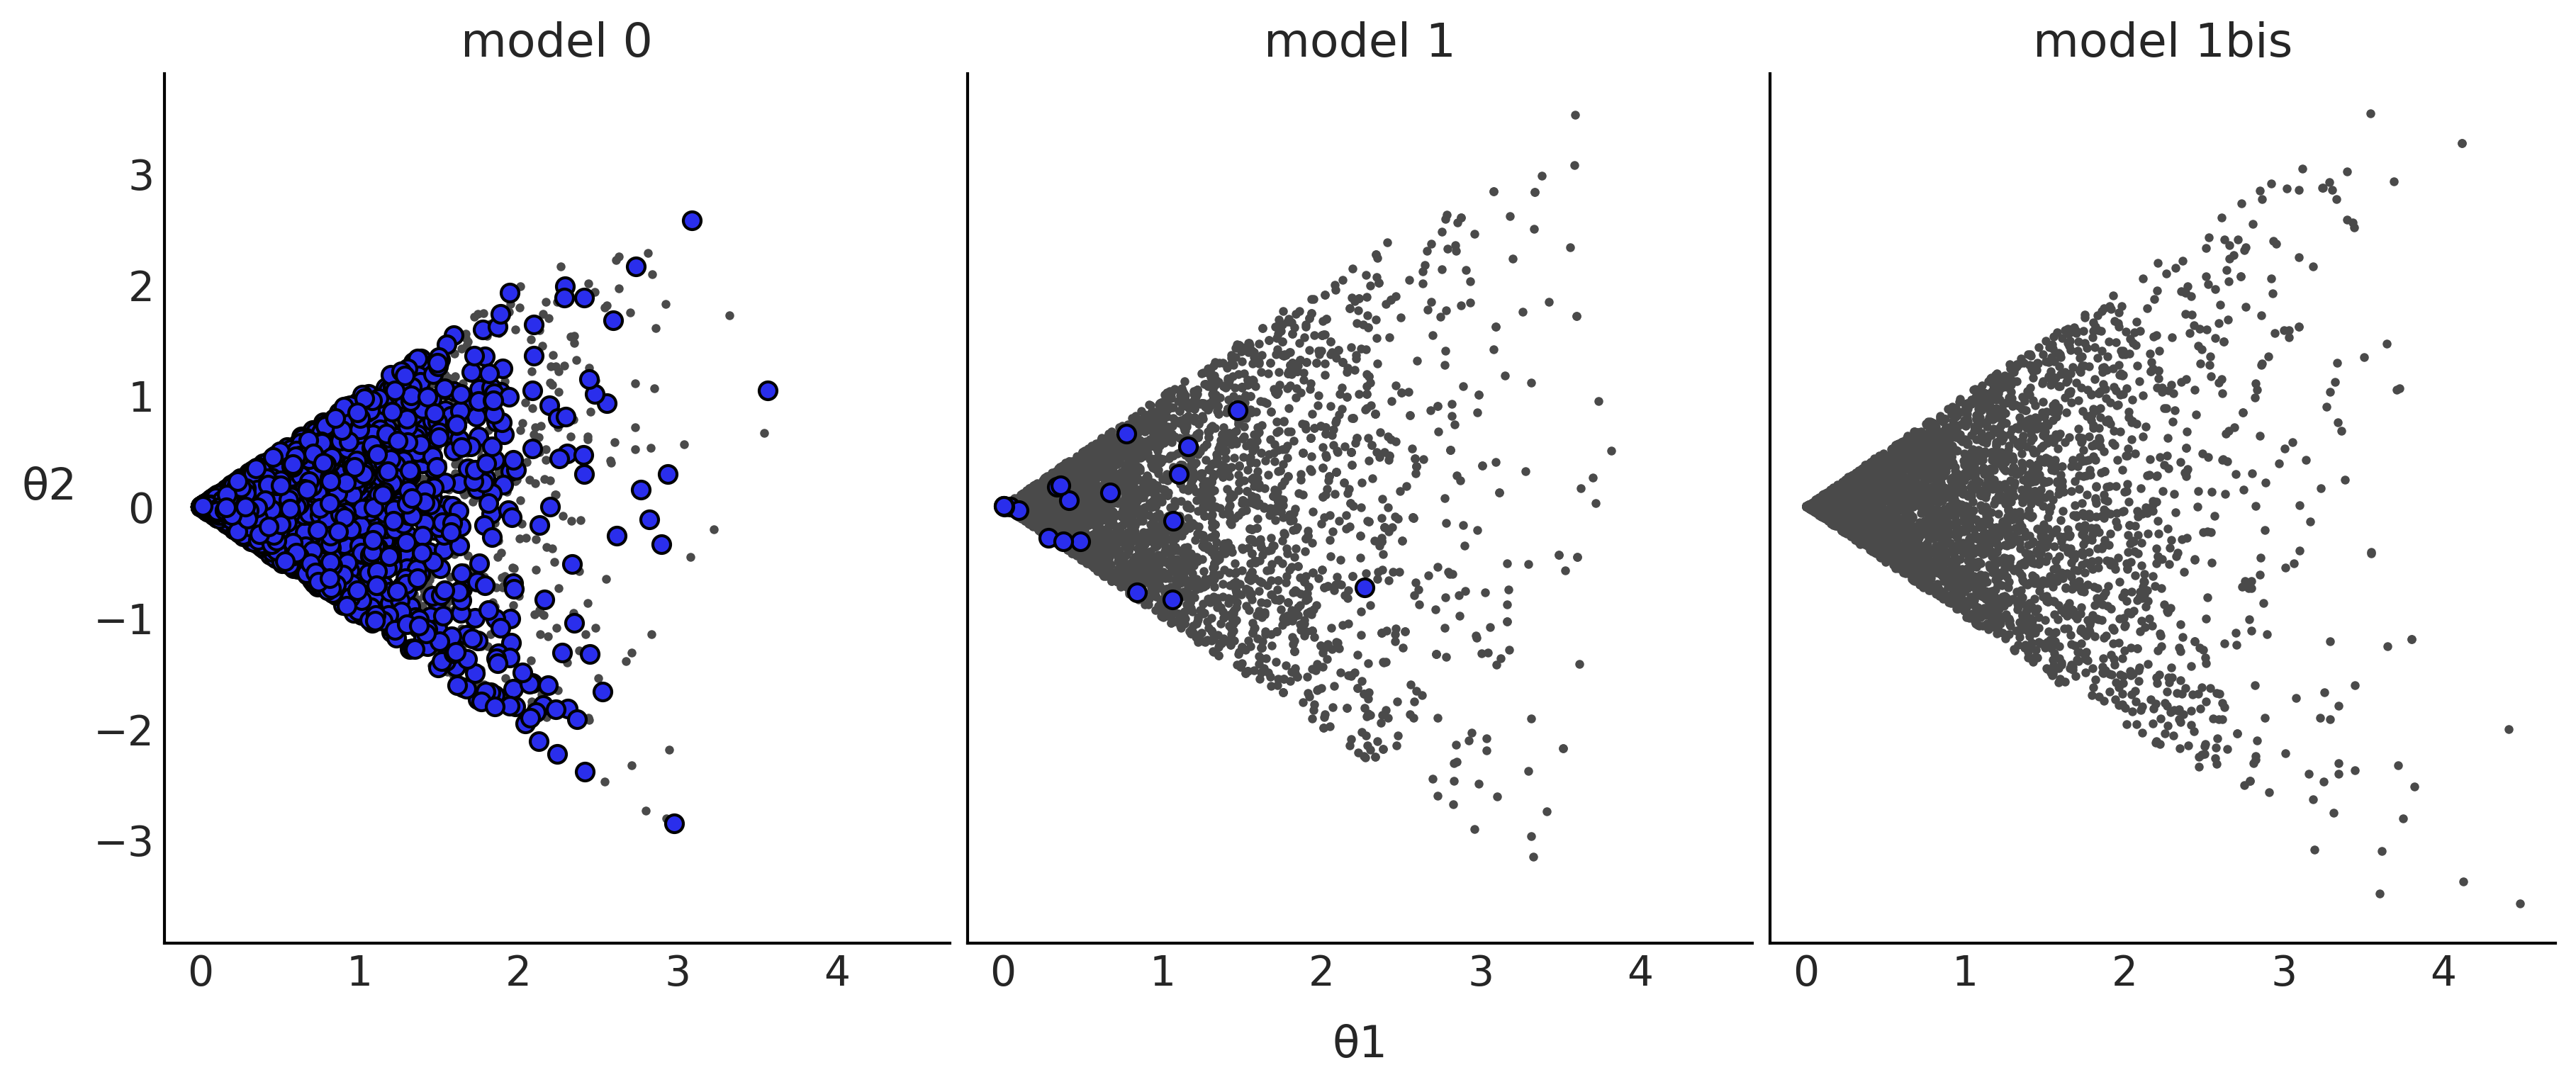

In [85]:
_, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)

for idata, ax, model in zip(idatas, axes, ["model 0", "model 1", "model 1bis"]):
    az.plot_pair(idata, divergences=True, scatter_kwargs={"color":"C1"}, divergences_kwargs={"color":"C4"}, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(model)
axes[0].set_ylabel('θ2', rotation=0, labelpad=15)
axes[1].set_xlabel('θ1', labelpad=10)

### 2.4.8. 采样器参数和其他诊断信息    
大部分抽样方法都有影响效果的超参数，比如有时增大 `target_accept` 可以消除 divergence。还有其他参数可以调整，比如有些模型更复杂需要更多的跌打，可以增加 tune 去增大 ESS 和减少 $\hat{R}$。也可以增加采样次数，但是一般效果不大。重新参数化、改进模型结构、提供更多信息的先验，甚至更改模型通常会更有效。

## 2.5. 模型比较
建模时不能过于简单从而丢失信息，也不能过于复杂从而过拟合。
    
一种有用的解决方案是计算泛化误差，也称为样本外预测准确性。这是指模型在新数据上的表现。
$$\text{ELPD} = \sum_{i=1}^{n} \int p_t(\tilde y_i) \; \log p(\tilde y_i \mid y_i) \; d\tilde y_i$$

上述公式被称为 expected log pointwise predictive density (ELPD)。其中 $p_t(\tilde y_i)$ 是真实分布，$p(\tilde y_i \mid y_i)$ 是模型预测的后验分布。    
     
现实生活中无法知道 $p_t(\tilde y_i)$ ，因此 ELPD 无法直接计算，可以通过下面公式代替：
$$\sum_{i=1}^{n} \log \int \ p(y_i \mid \boldsymbol{\theta}) \; p(\boldsymbol{\theta} \mid y) d\boldsymbol{\theta}$$

### 2.5.1. Cross-validation and LOO
Leave-one-out cross-validation (LOO-CV) 是交叉验证的一种特别方法，每次只留一个数据点作为测试集，其余作为训练集。
$$\text{ELPD}_\text{LOO-CV} = \sum_{i=1}^{n} \log
    \int \ p(y_i \mid \boldsymbol{\theta}) \; p(\boldsymbol{\theta} \mid y_{-i}) d\boldsymbol{\theta}
$$  

以上直接计算消耗很大，好在可以用 Pareto smoothed importance sampling leave-one-out cross validation (PSIS-LOO-CV) 近似，后面会称为 LOO 。以下是示例：

In [161]:
y_obs =  np.random.normal(0, 1, size=100)
idatas_cmp = {}

with pm.Model() as mA:
    σ = pm.HalfNormal("σ", 1)
    y = pm.SkewNormal("y", 0, σ, observed=y_obs)
    loglik = pm.Deterministic('log_likelihood', pm.logp(y, y_obs))
    idataA = pm.sample(return_inferencedata=True)
    idataA.add_groups({"posterior_predictive": {"y":pm.sample_posterior_predictive(idataA).posterior_predictive.y.values}})
    idataA.add_groups({"log_likelihood": {"y":idataA.posterior.log_likelihood}})
    idatas_cmp["mA"] = idataA

with pm.Model() as mB:
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", 0, σ, observed=y_obs)
    loglik = pm.Deterministic('log_likelihood', pm.logp(y, y_obs))
    idataB = pm.sample(return_inferencedata=True)
    idataB.add_groups({"posterior_predictive": {"y":pm.sample_posterior_predictive(idataB).posterior_predictive.y.values}})
    idataB.add_groups({"log_likelihood": {"y":idataB.posterior.log_likelihood}})
    idatas_cmp["mB"] = idataB

with pm.Model() as mC:
    μ = pm.Normal("μ", 0, 1)
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y", μ, σ, observed=y_obs)
    loglik = pm.Deterministic('log_likelihood', pm.logp(y, y_obs))
    idataC = pm.sample(return_inferencedata=True)
    idataC.add_groups({"posterior_predictive": {"y":pm.sample_posterior_predictive(idataC).posterior_predictive.y.values}})
    idataC.add_groups({"log_likelihood": {"y":idataC.posterior.log_likelihood}})
    idatas_cmp["mC"] = idataC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
Sampling: [y]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Sampling: [y]


In [162]:
cmp = az.compare(idatas_cmp)
cmp.round(2)

/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Va

rank  elpd_loo  p_loo  elpd_diff  weight    se   dse  warning scale
mA     0   -140.80   0.31       0.00    0.84  6.50  0.00     True   log
mB     1   -141.02   0.89       0.21    0.16  6.82  0.80    False   log
mC     2   -142.10   1.95       1.30    0.00  6.84  0.97    False   log

注意：`PyMC更换新版本后计算结果与原文不一致，而且mA出现warning`。以上模型中mB最好，但是给出的列表中mA最好（本应最差），这是因为mA的计算有问题。     
     
以上列含义：   

- rank：对比排名；
- elpd_loo：ELPD值；
- p_loo：惩罚项的值。我们可以粗略地认为这个值是估计的有效参数数量（但不要太认真）。该值可能低于具有更多结构（如分层模型）的模型中参数的实际数量，或者当模型具有非常弱的预测能力并且可能指示严重的模型错误指定时，该值可能远高于实际数量；
- elpd_diff：与最佳模型的ELPD差值；
- weight：分配给每个模型的权重。这些权重可以粗略地解释为给定数据的每个模型（在比较模型中）的概率；
- se：ELPD的标准误；
- dse：ELPD差值的标准误；
- warning：如果为 `True` 则这是一个警告，表明 LOO 近似可能不可靠；
- scale：报告值的计算方式，默认为对数刻度。

### 2.5.2. Expected Log Predictive Density

上述是全局比较，因此将模型和数据简化为单个数字。但LOO是逐点的总和，因此也可以通过`az.plot_elpd(.)`进行局部比较。


### 2.5.3. Pareto Shape Parameter

以上通过 $\text{ELPD}_\text{LOO-CV}$ 来逼近 LOO 。以上计算中 $\hat \kappa $ 会有问题， 特别是 $\hat \kappa > 0.7$时（mA）。    
这种情况下的建议为：

- 使用匹配矩法。通过一些额外的计算，可以转换从后验分布得出的 MCMC，以获得更可靠的重要性采样估计；
- 对有问题的观察结果执行精确的留一交叉验证或使用 k 折交叉验证；
- 使用对异常观察更稳健的模型。   
    
当以上问题发生时会在得到warning，可以可视化检查 $\hat \kappa $

/Users/admin/blog/rock_blog/env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


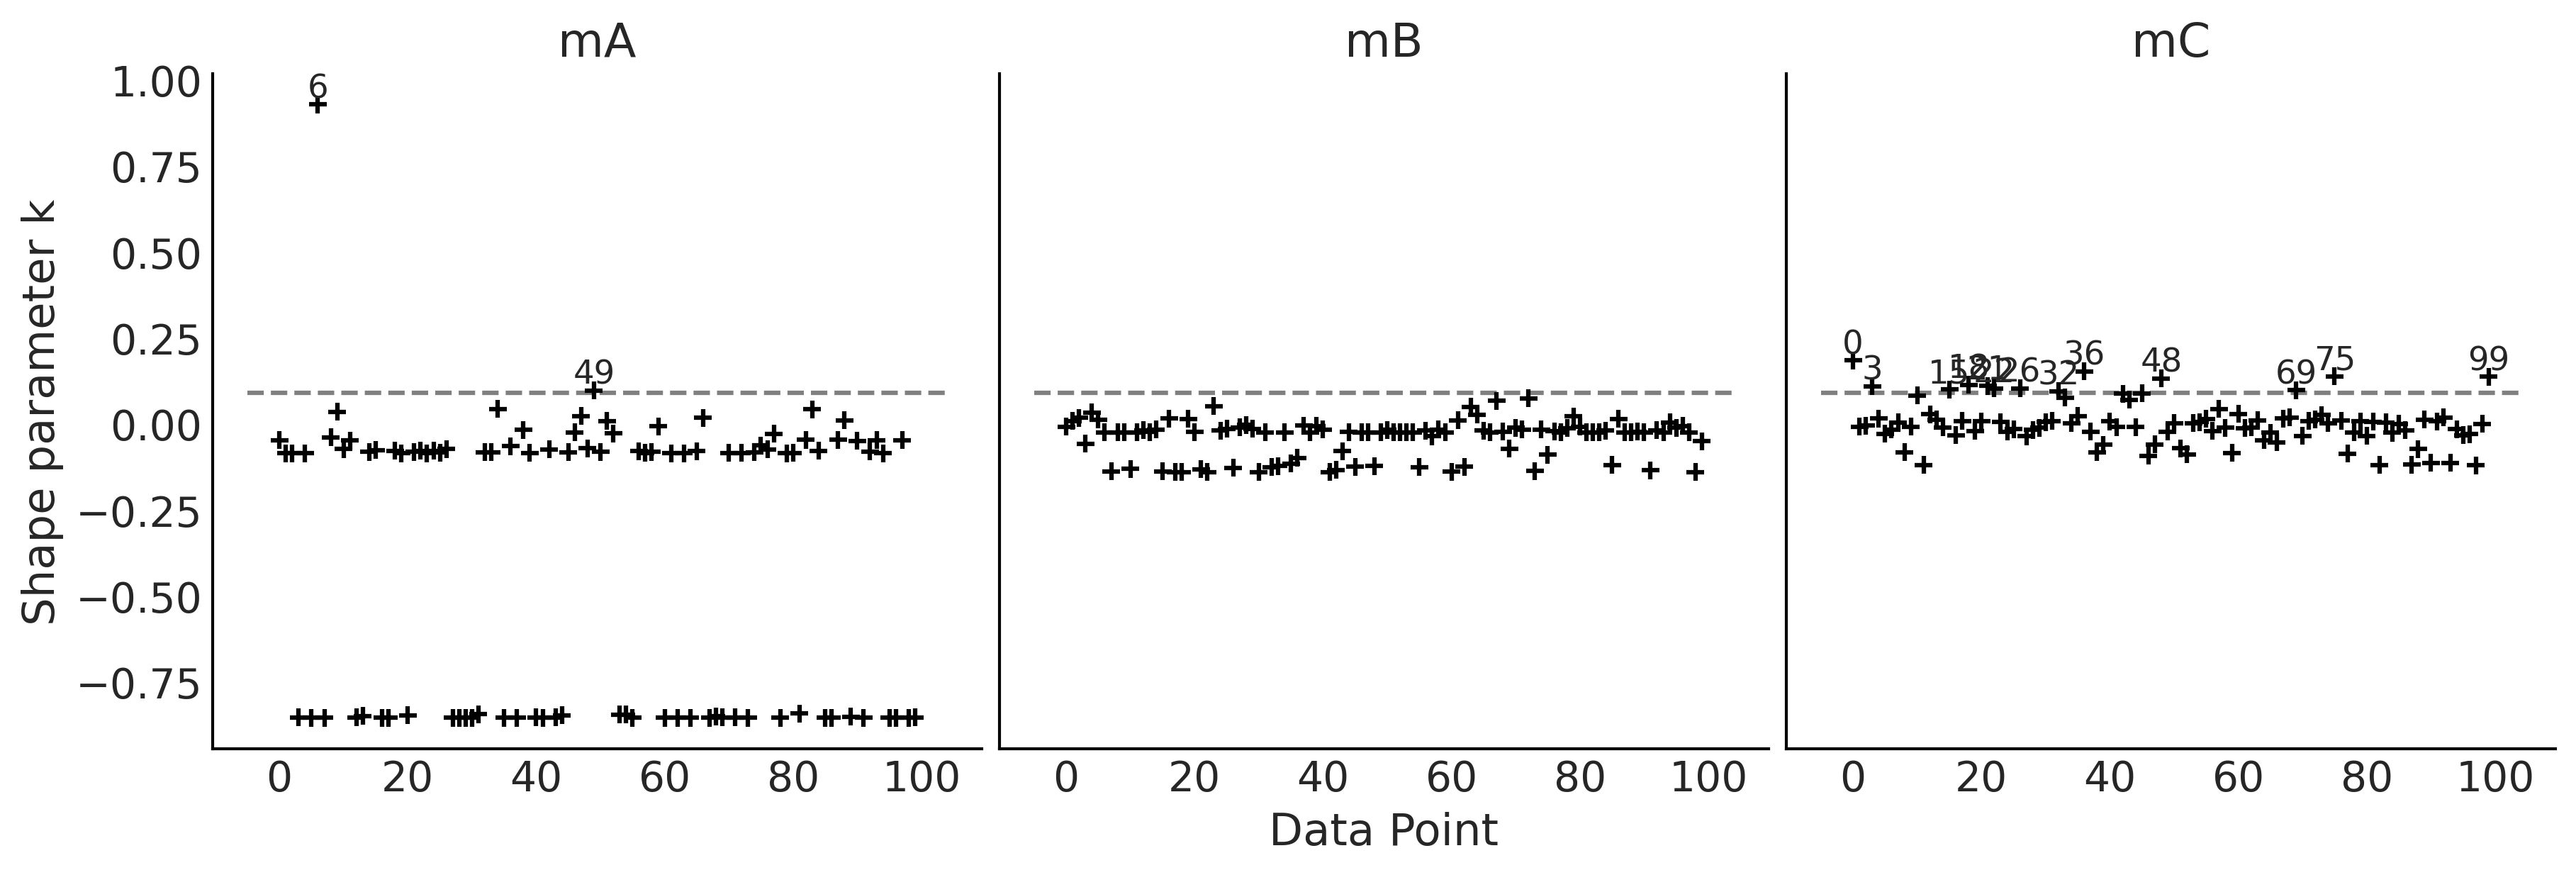

In [173]:
_, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for idx, (model, ax) in enumerate(zip(("mA", "mB", "mC"), axes)):
    loo_ = az.loo(idatas_cmp[model], pointwise=True)
    az.plot_khat(loo_, ax=ax, threshold=0.09, show_hlines=True, hlines_kwargs={"hlines":0.09, "ls":"--"})
    ax.set_title(model)
    if idx:
        axes[idx].set_ylabel("")
    if not idx % 2:
        axes[idx].set_xlabel("")

### 2.5.4. $\hat {\kappa}$ 很大时 p_loo 的含义

p_loo 可以宽松地解释为模型中参数的估计有效数量。当 $\hat {\kappa}$ 很大时，它还可以提供额外信息。具体可参考原文。

### 2.5.5. LOO-PIT

 LOO除了声明一个模型比另一个模型更好之外，还可以用于其他目的。我们可以通过比较模型来更好地理解它们。随着模型复杂性的增加，仅仅通过查看其数学定义或我们用来实现它的代码来理解它就变得更加困难。因此，使用 LOO 或其他工具（如后验预测检查）比较模型可以帮助我们更好地理解它们。  
    
对 posterior predictive checks（后验预测检查）的一个批评是我们使用数据两次，一次是为了拟合模型，一次是为了批评它。 LOO-PIT 为这个问题提供了答案。    


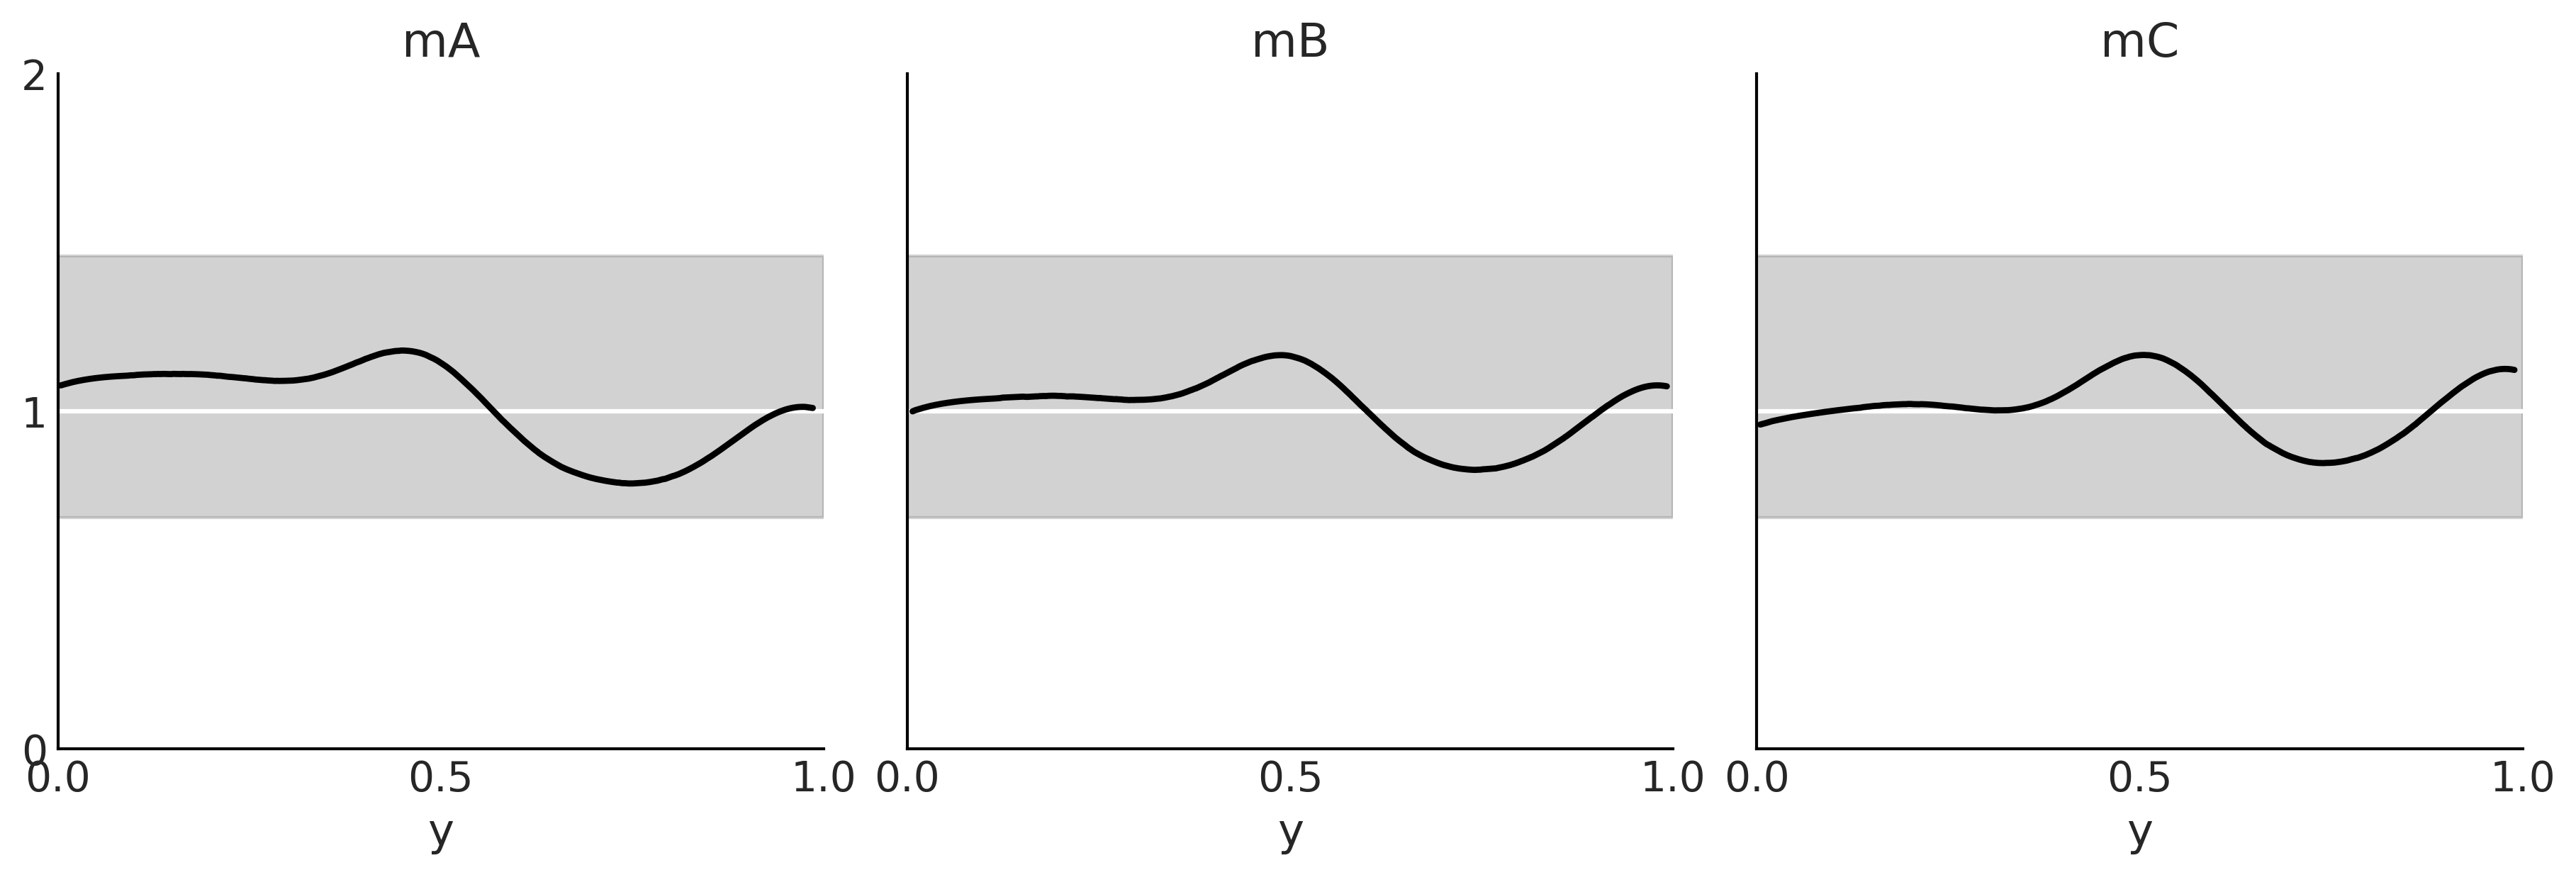

In [175]:
_, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for model, ax in zip(("mA", "mB", "mC"), axes):
    az.plot_loo_pit(idatas_cmp[model], y="y", legend=False, use_hdi=True, ax=ax)
    ax.set_title(model)
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 1, 2])

### 2.5.6. Model Averaging
像我们关于参数不确定性的贝叶斯学派一样。如果我们不能绝对确定模型就是模型（通常我们不能），那么我们应该在分析时考虑到这种不确定性。考虑模型不确定性的一种方法是对所有考虑的模型进行加权平均，为似乎能更好地解释或预测数据的模型赋予更多权重。    
    
贝叶斯模型加权的一种方法是通过其 marginal likelihoods ，这称为 Bayesian Model Averaging  贝叶斯模型平均。虽然这在理论上很有吸引力，但在实践中却存在问题。另一种方法是使用 LOO 的值来估计每个模型的权重：
$$w_i = \frac {e^{-\Delta_i }} {\sum_j^k e^{-\Delta_j }}$$

其中 $\Delta_i $ 是当前与最优模型的 LOO 之差。这种方法称为 pseudo Bayesian model averaging 伪贝叶斯模型平均。    
    
模型平均的另一个选择是叠加预测分布。主要思想是将多个模型组合在一个元模型中，从而最小化元模型和真实生成模型之间的差异。当使用对数评分规则时，这相当于计算：
$$\max_{w} \frac{1}{n} \sum_{i=1}^{n}log\sum_{j=1}^{k} w_j p(y_i \mid y_{-i}, M_j)$$

其中 n 是样本个数，k 是模型个数。为了有解约束 $w_j \geq 0$ 而且 $\sum_{j=1}^{k} w_j = 1$ 。 $p(y_i \mid y_{-i}, M_j)$ 是第 j 个模型的 leave-one-out 预测分布。   
    


## 2.6. 练习
待完善